With this notebook, different variants were tried out to generate a forecast for our time series with deep learning models. Several deep learning architectures were used:

Convolutional Neural Networks (CNN's)
Long Short Therm Memory Networks (RNN's, LSTM's)
                               
The final models were trained to a resolution of 20 minutes, as smaller resolutions of 5 minutes contain too much variance and would make the prediction and training more difficult and significantly less accurate. Higher resolutions of one hour, on the other hand, would be too long for our use case.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wandb

import torch
from torch import nn

from helper import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: simonluder. Use `wandb login --relogin` to force relogin


True

## Load Data

In [2]:
# read in live data
df = pd.read_csv("../data/processed/live_20.csv")

# update timestamp dtype
df = update_timestamps(df)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32816 entries, 0 to 32815
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   published           32816 non-null  datetime64[ns, UTC]
 1   free                32816 non-null  float64            
 2   total               32816 non-null  float64            
 3   anteil_frei         32816 non-null  float64            
 4   auslastung          32816 non-null  float64            
 5   auslastung_prozent  32816 non-null  float64            
 6   missing             32816 non-null  float64            
 7   title               32816 non-null  object             
 8   name                32816 non-null  object             
 9   id2                 32816 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(6), object(3)
memory usage: 2.5+ MB


Create an additional column with integrated values

In [3]:
def integrate_garage(df, old, new=None, shift=1):
    '''
    Integrates a column within a dataframe for 
    Args: 
        df: pandas dataframe
        old: original column name
        new: integrated column name
        shift: number of lags to integrate over
    Returns:
        df with integrated column
    '''
    if new is None:
        new = old
    df[new] = df[old] - df[old].shift(shift)
    return df

def integrate_df(df, old, new=None, shift=1):
    '''
    Integrates a column within a dataframe per garage
    Args: 
        df: pandas dataframe
        old: original column name
        new: integrated column name
        shift: number of lags to integrate over
    Returns:
        df with integrated column
    '''
    new_df = pd.DataFrame()
    df = df.copy()
    for t in set(df["title"]):
        sub_df = df.loc[df["title"]==t]
        sub_df = sub_df.sort_values("published")
        sub_df = integrate_garage(sub_df, old, new, shift)
        new_df = new_df.append(sub_df)

    return new_df

df = integrate_df(df, "free", "free [i]")
df = df.dropna()

In [4]:
df.head()

,published,free,total,anteil_frei,auslastung,auslastung_prozent,missing,title,name,id2,free [i]
20,2022-10-20 01:00:00+00:00,917.214286,1114.0,0.823352,0.176648,17.664786,0.0,Parkhaus City,City,city,6.547619
41,2022-10-20 01:20:00+00:00,931.000000,1114.0,0.835727,0.164273,16.427289,0.0,Parkhaus City,City,city,13.785714
57,2022-10-20 01:40:00+00:00,950.857143,1114.0,0.853552,0.146448,14.644781,0.0,Parkhaus City,City,city,19.857143
69,2022-10-20 02:00:00+00:00,963.571429,1114.0,0.864965,0.135035,13.503462,0.0,Parkhaus City,City,city,12.714286
92,2022-10-20 02:20:00+00:00,966.428571,1114.0,0.867530,0.132470,13.246986,0.0,Parkhaus City,City,city,2.857143


## torch

Ckeck if training on gpu is available. If not it uses the cpu.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [6]:
sub_df = df.loc[df["title"]=="Parkhaus Steinen"]["free"]

In [7]:
def sliding_window(data, x_len, y_len, y_shift):
    '''
    Creates a sliding window over the dataset and X, Y
    Args:
        data: pandas series
        x_len: nr of timestamps in x per sample
        y_len: nr of timestamps in y per sample
        y_shift: shift between first x and first y timestamp
    Returns:
        X, Y as np.array
    '''
    X = []
    Y = []
    
    for i in range(len(data) - (x_len + y_len)):
        x = data[i:(i+x_len)].to_numpy()
        y = data[(i+y_shift):(i+y_shift+y_len)].to_numpy()
        X.append(x)
        Y.append(y)
        
    return np.array(X), np.array(Y)


def train_test_split(df, x_len, y_len, y_shift, train_ratio):
    '''
    Creates a sliding window over the dataset and X, Y and train/test
    Args:
        data: pandas series
        x_len: nr of timestamps in x per sample
        y_len: nr of timestamps in y per sample
        y_shift: shift between first x and first y timestamp
        train_ratio: proportion of training samples in the split
    Returns:
        X, Y as np.array
    '''

    len_train = int(len(df) * train_ratio)
    
    X_train, Y_train = sliding_window(df[:len_train], x_len, y_len, y_shift)
    X_test, Y_test = sliding_window(df[len_train:], x_len, y_len, y_shift)
    
    return X_train, Y_train, X_test, Y_test

# x_len = 12
# y_len = 12
# y_shift = 1
x_len = 24
y_len = 1
y_shift = x_len
train_ratio = 0.8


X_train, Y_train, X_test, Y_test = train_test_split(sub_df, x_len, y_len, y_shift, train_ratio)

## Create the dataset

In this section the dataset is used to create train batches that our model can use in training

In [8]:
from torch.utils.data import Dataset

class TimeSeriesDataSet(Dataset):
    def __init__(self, sequences, labels):
        self.labels = labels
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequences = self.sequences[idx]
        sequences = torch.from_numpy(self.sequences[idx]).float()
        
        labels = self.labels[idx]
        labels = torch.from_numpy(self.labels[idx]).float()

        return sequences, labels

In [9]:
train_set = TimeSeriesDataSet(X_train, Y_train)
test_set = TimeSeriesDataSet(X_test, Y_test)

In [10]:
from torch.utils.data import DataLoader
# Set seed 
torch.manual_seed(42)
batch_size = 64

train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

#### Example batch shape

In [11]:
example_batch = iter(train_dataloader)
sequences, labels = example_batch.next()
print("Shape of X:", np.shape(sequences))
print("Shape of y:", np.shape(labels))

Shape of X: torch.Size([64, 24])
Shape of y: torch.Size([64, 1])


#### Single trainig sample within batch

In [12]:
print("X:", sequences[0], "\n")
print("y:", labels[0])

X: tensor([233.4667, 271.5714, 303.9231, 343.5833, 382.2143, 406.6429, 422.0000,
        432.6429, 435.5833, 440.0000, 441.0000, 441.0000, 442.7143, 444.0000,
        444.0000, 444.0000, 440.9375, 439.0000, 439.0000, 439.0000, 439.0000,
        439.0000, 439.0000, 439.0000]) 

y: tensor([438.])


The lstm predicts the next point, taking into account the previous value and a hidden state. For the loss we only view the last output of the network.

### LSTM Model Structure

Define Structure of the lstm model

In [13]:
class LSTMForecaster2(nn.Module):
    '''
    LSTM model for predicting timeseries
    Args:
        input_size (int): nr of input features
        hidden_size (int): hidden layer size
        num_layers (int): number of layers in the lstm
        seq_length (int): length of the prediction
    '''
    def __init__(self, hidden_size, dropout=0):
        super(LSTMForecaster2, self).__init__()
        
        self.hidden_size = hidden_size
      
        self.dropout = dropout
        
        self.lstm1 = nn.LSTMCell(1, hidden_size)
        self.lstm2 = nn.LSTMCell(hidden_size, hidden_size)
        self.linear = nn.Linear(hidden_size, 1)


    def forward(self, X, future=0):
        outputs = []
        n_samples = X.size(0)
        
        h_t = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(device)
        c_t = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(device)
        
        h_t2 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(n_samples, self.hidden_size, dtype=torch.float32).to(device)
    
        for input_t in X.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
        outputs.append(output)
            
        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        outputs = torch.cat(outputs, dim=1)
        return outputs

### Model Trainer

Create a trainer class that controlls the training of the model

In [14]:
from torch.optim import Adam
from torch.nn import MSELoss


class ModelTrainer():
    
    def __init__(self, model, lr):
        self.model = model
        self.lr = lr
        self.criterion = MSELoss(reduction="sum")
        self.log = dict(
            train=[], 
            test=[]
        )
        
    def predict(self, x, y, future=0):
        with torch.no_grad():
            labels_pred = self.model(x, future)
            loss = self.criterion(labels_pred[:,-future:].float(), y)
            y = labels_pred.detach().numpy()
            return y

    def train_model(self, train_dataloader, test_dataloader=None, num_epochs = 100):

        optimiser = Adam(self.model.parameters(), lr=self.lr)
        

        for epoch in range(num_epochs):
            print("epoch:", epoch)
            
            model.train()
            
            train_epoch_loss = 0
            len_train = 0
            test_epoch_loss = None
            len_test = None

            for batch, (sequences, labels) in enumerate(train_dataloader):
                sequences = sequences.to(device)
                labels = labels.to(device)
                
                len_train += len(labels)

                labels_pred = self.model(sequences)
                loss = self.criterion(labels_pred.float(), labels)
                
                optimiser.zero_grad()
                loss.backward()
                optimiser.step()

                train_epoch_loss += loss.item()
                
            MAE_train = np.sqrt(train_epoch_loss / len_train)
            
                
            model.eval()
            
            if test_dataloader is not None:
            
                test_epoch_loss = 0
                len_test = 0
                
                for batch, (sequences, labels) in enumerate(test_dataloader):
                    sequences = sequences.to(device)
                    labels = labels.to(device)
                    
                    len_test += len(labels)
                    
                    with torch.no_grad():
                        
                        labels_pred = self.model(sequences)
                        loss = self.criterion(labels_pred.float(), labels)
                        
                        test_epoch_loss += loss.item()
                MAE_test = np.sqrt(test_epoch_loss / len_test)
                        
            self.log["train"].append(MAE_train)
            self.log["test"].append(MAE_test)
            
            wandb.log(
                {
                "MSE_train": train_epoch_loss,
                "MSE_test": test_epoch_loss,
                "MAE_train": MAE_train,
                "MAE_test": MAE_test
                }, step=epoch)

            print(MAE_train, MAE_test)

### Start Training

In [15]:
hidden_size = 50
num_epochs = 280
lr = 0.005
config = {"num_epochs":num_epochs, "lr":lr, "batch_size":batch_size}
model = LSTMForecaster2(hidden_size).to(device)

trainer = ModelTrainer(model, lr=lr)  

with wandb.init(project="chx_models", config=config) as run:
    
    # set run name to training start timestamp
    run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    
    # run model training
    trainer.train_model(train_dataloader, test_dataloader, num_epochs=num_epochs)

epoch: 0
292.2899209863671 311.4761567856223
epoch: 1
285.521369155764 305.32167353523585
epoch: 2
279.74001336490886 299.39526952637834
epoch: 3
274.1625873517493 293.79352247352665
epoch: 4
268.82956695295155 288.3533761398503
epoch: 5
263.67685756758834 283.0373848121458
epoch: 6
258.67829453187505 277.8514190888568
epoch: 7
253.79501110648079 272.8504796832743
epoch: 8
248.89641248641334 267.43819567231657
epoch: 9
243.84935940303257 262.46251991626434
epoch: 10
239.13023091500017 257.52527398504293
epoch: 11
234.49576213931948 252.73543461233342
epoch: 12
229.99000701807321 247.99289858702437
epoch: 13
225.5289297239156 243.42865508330277
epoch: 14
221.21398046868276 238.90699354037335
epoch: 15
216.99747023821104 234.38579265193937
epoch: 16
212.79718319674862 230.05375859469692
epoch: 17
208.73821994532835 225.78251052876902
epoch: 18
204.7517513543231 221.60927476651466
epoch: 19
200.83240301845512 217.48923944076947
epoch: 20
196.99765069869477 213.46728226024777
epoch: 21
193

8.547695180067585 9.20706327049076
epoch: 174
8.38010121788165 9.72913106547727
epoch: 175
8.607996821195721 8.892654444967413
epoch: 176
8.504788313766829 10.77009084212914
epoch: 177
8.6850159891421 9.591556947425437
epoch: 178
8.609699754556708 8.760849118291052
epoch: 179
8.33404818358547 8.606893350247448
epoch: 180
8.525755049408499 8.92975441497719
epoch: 181
8.24558512773475 9.232529920339786
epoch: 182
8.412640202099238 10.814638284313748
epoch: 183
9.36191763292507 9.345674880727348
epoch: 184
8.792709333281591 8.624122161105163
epoch: 185
8.861788300014528 8.429563884003896
epoch: 186
8.199735164996119 10.919693242740333
epoch: 187
8.893749637955278 8.938181682542448
epoch: 188
8.346349551581406 8.310005543054283
epoch: 189
8.29036552348645 9.73219905673876
epoch: 190
9.050764886233672 9.183430147472526
epoch: 191
8.407577832205634 8.674927547590157
epoch: 192
8.74211924354366 10.516720644877854
epoch: 193
8.290442714321918 8.936694822937747
epoch: 194
8.360966680661951 8.25

MAE_test,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▇▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▅▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,8.2655
MAE_train,7.13023
MSE_test,26302.6474
MSE_train,82106.80383


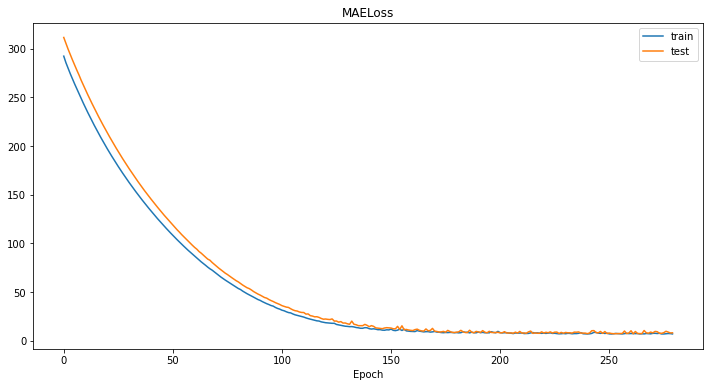

In [16]:
plt.figure(figsize=(12,6))
plt.plot(trainer.log["train"], label="train")
plt.plot(trainer.log["test"], label="test")
plt.title("MAELoss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [17]:
example_batch = iter(test_dataloader)
sequences, labels = example_batch.next()
sequences = sequences.to(device)
labels = labels.to(device)

with torch.no_grad():
    labels_pred = trainer.model(sequences, future=3*24)
    restults = labels_pred.detach().cpu().numpy()

## Repeat process with CNN Model

In [18]:
x_len = 24
y_len = 1
y_shift = x_len
train_ratio = 0.8
batch_size = 64

torch.manual_seed(42)

In [19]:
# train test split
X_train, Y_train, X_test, Y_test = train_test_split(sub_df, x_len, y_len, y_shift, train_ratio)

# generate torch dataset structure
train_set = TimeSeriesDataSet(X_train, Y_train)
test_set = TimeSeriesDataSet(X_test, Y_test)

# setup dataloaders
train_dataloader = DataLoader(
    dataset=train_set, 
    batch_size=batch_size, 
    shuffle=True)

test_dataloader = DataLoader(
    dataset=test_set, 
    batch_size=batch_size, 
    shuffle=False)

In [20]:
example_batch = iter(train_dataloader)
sequences, labels = example_batch.next()
print("Shape of X:", np.shape(sequences))
print("Shape of y:", np.shape(labels))

Shape of X: torch.Size([64, 24])
Shape of y: torch.Size([64, 1])


In [21]:
print("X:", sequences[0], "\n")
print("y:", labels[0])

X: tensor([233.4667, 271.5714, 303.9231, 343.5833, 382.2143, 406.6429, 422.0000,
        432.6429, 435.5833, 440.0000, 441.0000, 441.0000, 442.7143, 444.0000,
        444.0000, 444.0000, 440.9375, 439.0000, 439.0000, 439.0000, 439.0000,
        439.0000, 439.0000, 439.0000]) 

y: tensor([438.])


The cnn predicts the next point, taking into account all previous values at once and using convolutional filters for pattern detection. For the training, therefore only need one value in y for n values in X per train sample.

### CNN Model Structure

In [22]:
import torch.nn.functional as F

class CNNForecaster(nn.Module):
    def __init__(self, kernel_size=3, pool_size=2, padding=0, conv1_channels = 120, 
                 conv2_channels=120, conv3_channels=120, fc_linear_1=180, dropout=0.4):
        '''Convolutional Net class'''
        super(CNNForecaster, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=conv1_channels, kernel_size=kernel_size, padding=padding) 
        self.conv2 = nn.Conv1d(in_channels=conv1_channels, out_channels=conv2_channels, kernel_size=kernel_size, padding=padding) 
        self.conv3 = nn.Conv1d(in_channels=conv2_channels, out_channels=conv3_channels, kernel_size=kernel_size, padding=padding) 
        
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=1)
        
        self.fc1 = nn.Linear(in_features=conv3_channels*15, out_features=fc_linear_1)
        self.fc2 = nn.Linear(in_features=fc_linear_1, out_features=1)
        
        self.conv3_channels = conv3_channels
        
        self.dropout = nn.Dropout(p=dropout)
        
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        '''
        Applies the forward pass
        Args:
            x (torch.tensor): input feature tensor
        Returns:
            x (torch.tensor): output tensor of size num_classes
        '''
        x = x.reshape(x.shape[0], 1, x.shape[1])
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
#         print(x.shape)
        x = self.flatten(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [23]:
num_epochs = 300
lr = 0.00005
config = {"num_epochs":num_epochs, "lr":lr, "batch_size":batch_size}
model = CNNForecaster().to(device)

trainer = ModelTrainer(model, lr=lr)  

with wandb.init(project="chx_models", config=config) as run:
    
    # set run name to training start timestamp
    run.name = "{}".format(datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))
    
    # run model training
    trainer.train_model(train_dataloader, test_dataloader, num_epochs=num_epochs)

epoch: 0
240.54313027650534 170.8498681832692
epoch: 1
151.01576609714337 141.8493871250047
epoch: 2
135.0751073534572 120.14352775351344
epoch: 3
114.0177626863939 97.6865791279996
epoch: 4
91.40714687911715 70.63374250926003
epoch: 5
76.11871024613859 56.52457334597045
epoch: 6
65.16169123232581 49.012225280723015
epoch: 7
59.27062399869809 45.391561386668826
epoch: 8
55.642671319894205 42.35900667723718
epoch: 9
53.8187416373877 42.11551467330347
epoch: 10
52.21141005080244 36.855756744985385
epoch: 11
49.16367352483202 36.621139255924106
epoch: 12
47.06126327681149 34.19504987090531
epoch: 13
45.45986207989574 40.016214319487034
epoch: 14
45.18897401665608 38.8570527089518
epoch: 15
44.981984671084604 33.11839256187883
epoch: 16
42.206487270613486 35.63186148304713
epoch: 17
42.17601225315373 29.82982383141596
epoch: 18
40.88605787278284 29.3544216635294
epoch: 19
40.822384329319725 29.644748855655607
epoch: 20
40.6869947608128 28.84354176777912
epoch: 21
40.297839256374345 27.9146

29.82107946854883 14.940886123809165
epoch: 175
29.50749723531471 12.763901376331868
epoch: 176
29.32476853501751 17.276759790905267
epoch: 177
30.755888013029434 12.33372775543186
epoch: 178
30.27626442845737 15.35238786788222
epoch: 179
29.83977968459866 16.9687499684686
epoch: 180
29.45992061306441 15.775377495167318
epoch: 181
29.309569404025382 13.932435113188696
epoch: 182
29.45367145868227 13.574212668175784
epoch: 183
30.02864918563104 12.161983934243233
epoch: 184
30.52184802322913 15.648924873909092
epoch: 185
30.012152184315607 13.054072537590807
epoch: 186
30.150541445843956 22.215525028039714
epoch: 187
29.075670567142318 12.978089954606219
epoch: 188
29.817546211327123 13.689069694904267
epoch: 189
29.808398341691916 18.888529381817744
epoch: 190
30.90094746254259 12.656566518263322
epoch: 191
28.70230216421548 14.017315306796133
epoch: 192
29.10581817365151 19.095449571121776
epoch: 193
29.3595660803868 12.345004338265122
epoch: 194
28.826830474156512 13.946335445538246


MAE_test,█▄▃▃▃▂▂▃▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▄▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,10.99508
MAE_train,29.35034
MSE_test,46543.37544
MSE_train,1391229.83984


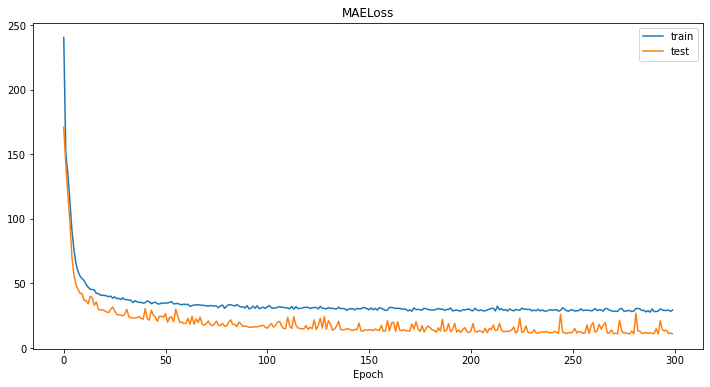

In [24]:
plt.figure(figsize=(12,6))
plt.plot(trainer.log["train"], label="train")
plt.plot(trainer.log["test"], label="test")
plt.title("MAELoss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

### Train LSTM for every garage

In [25]:
torch.manual_seed(42)

x_len = 24
y_len = 1
y_shift = x_len
train_ratio = 0.8
batch_size = 64
num_epochs = 300
lr = 0.005

config = {"num_epochs":num_epochs, "lr":lr, "batch_size":batch_size, "type":"lstm"}
          


garage_names = list(set(df["title"]))

for garage_name in garage_names:
    print("Training model for:", garage_name)
    sub_df = df.loc[df["title"]==garage_name]["free"]
    
    #train test split
    X_train, Y_train, X_test, Y_test = train_test_split(sub_df, x_len, y_len, y_shift, train_ratio)
    
    # generate torch dataset
    train_set = TimeSeriesDataSet(X_train, Y_train)
    test_set = TimeSeriesDataSet(X_test, Y_test)

    # setup dataloaders
    train_dataloader = DataLoader(
        dataset=train_set, 
        batch_size=batch_size, 
        shuffle=True)

    test_dataloader = DataLoader(
        dataset=test_set, 
        batch_size=batch_size, 
        shuffle=False)
    
    # train the model
    model = LSTMForecaster2(hidden_size).to(device)

    trainer = ModelTrainer(model, lr=lr)  

    with wandb.init(project="chx_models", config=config) as run:

        # set run name to training start timestamp
        run.name = "{}_lstm_{}".format(garage_name, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

        # run model training
        trainer.train_model(train_dataloader, test_dataloader, num_epochs=num_epochs)

    
    torch.save(model.state_dict(), os.path.join(os.getcwd(), '../models', f'{garage_name}_lstm.pth'))

Training model for: Parkhaus City


epoch: 0
689.3283270074288 694.533713041445
epoch: 1
682.3213911383356 688.1971275172921
epoch: 2
676.1270885995328 682.1540143619071
epoch: 3
670.1709072256426 676.3013510042175
epoch: 4
664.3767767976148 670.5532205204331
epoch: 5
658.6877490693097 664.9013663151549
epoch: 6
653.0994050045808 659.3100071218936
epoch: 7
647.5595931073734 653.8336323178856
epoch: 8
642.127220162068 648.3797733262535
epoch: 9
636.7022062006735 643.065934831086
epoch: 10
631.2981992756424 637.5887851816781
epoch: 11
625.8609990188551 632.1973950731342
epoch: 12
620.527353373588 626.8968592995784
epoch: 13
615.254641083359 621.6459677523924
epoch: 14
610.0496300167646 616.3972720137742
epoch: 15
604.8428253221272 611.267979395231
epoch: 16
599.7206248444163 606.1450422517266
epoch: 17
594.6088461132755 601.1072799534098
epoch: 18
589.5772212740255 596.0564780116963
epoch: 19
584.5565046432578 591.0240593046514
epoch: 20
579.5757533489208 586.0882392423223
epoch: 21
574.64588247692 581.1373720828245
epoch:

96.10214790948919 100.41213405591397
epoch: 175
94.85682462440474 99.39018127618874
epoch: 176
93.28161643737891 97.2989335847386
epoch: 177
91.01982111983799 94.70672488089821
epoch: 178
89.71918328788554 95.33448996256391
epoch: 179
88.30936147602588 91.86619791260227
epoch: 180
86.78521429695778 91.52960013822619
epoch: 181
85.54623843632001 89.87233617961648
epoch: 182
84.01226299069283 88.19498802674887
epoch: 183
82.55949515312022 86.35731404874238
epoch: 184
80.96394303388655 84.79637064721062
epoch: 185
79.59353032539418 83.70714755671948
epoch: 186
78.12285229246048 81.80451588098221
epoch: 187
76.9243489035664 80.62118522244053
epoch: 188
75.30654966344974 79.66155125841206
epoch: 189
74.16996078870362 78.77380943136197
epoch: 190
72.9272439770398 78.77363676206393
epoch: 191
72.35693772352452 75.41029752088441
epoch: 192
70.05892191339503 73.51081296365062
epoch: 193
68.69388069803625 72.70062755076106
epoch: 194
67.58875865151417 71.66565962567131
epoch: 195
66.165970535670

MAE_test,██▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
MAE_train,██▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁
MSE_test,██▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,██▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,20.49305
MAE_train,15.63134
MSE_test,161686.52295
MSE_train,394607.0498


Training model for: Parkhaus Kunstmuseum


epoch: 0
298.34108658944115 294.1697401823666
epoch: 1
290.4392541849621 286.96827289959083
epoch: 2
283.29884764026735 280.1147593922589
epoch: 3
276.50445483733466 273.5337903370785
epoch: 4
269.94700116232536 267.1493964438105
epoch: 5
263.5565627426225 260.92158986023907
epoch: 6
257.3020350271295 254.8282513830091
epoch: 7
251.17614497589847 248.8352673558
epoch: 8
245.14897931426012 242.96521608174564
epoch: 9
239.23279285993917 237.1929750364792
epoch: 10
233.41431700380537 231.51873427481206
epoch: 11
227.68855911872333 225.94898499666408
epoch: 12
222.06135755017772 220.47224817629336
epoch: 13
216.52268791238703 215.09811245319037
epoch: 14
211.0766343966932 209.82277308218025
epoch: 15
205.73530911066453 204.6172376432317
epoch: 16
200.4647118487302 199.53196778669619
epoch: 17
195.29987698527717 194.53143426293886
epoch: 18
190.21628658218137 189.6392732987361
epoch: 19
185.2407686665141 184.8186384796303
epoch: 20
180.33969038461439 180.11103720880578
epoch: 21
175.5363814

4.515815966882311 5.385238348703397
epoch: 175
4.75870713473929 5.804490424930403
epoch: 176
4.537219585992039 4.753482575008463
epoch: 177
4.5771894830383415 5.425854572042791
epoch: 178
4.826716839013708 4.777315280625844
epoch: 179
4.506939151979885 4.88905062595443
epoch: 180
4.343135424928913 4.470914136364921
epoch: 181
4.405675170892794 4.510961078109947
epoch: 182
4.400298462399072 4.871435213153017
epoch: 183
4.314000785790585 4.359611882158013
epoch: 184
4.387510603898749 5.918337324209196
epoch: 185
4.8867993514557515 5.927370541598041
epoch: 186
4.527925540467392 5.155924142442385
epoch: 187
4.106168339877683 4.644708039722397
epoch: 188
4.1013686307012325 4.966398639668098
epoch: 189
4.142853174066757 5.359851101601911
epoch: 190
4.439455067273275 5.740976729485211
epoch: 191
4.419476154375778 4.808105686416741
epoch: 192
4.340977809070904 4.921858205552349
epoch: 193
4.375462449816672 4.8198743853703165
epoch: 194
4.423785760436147 4.65923479441041
epoch: 195
4.3665464741

MAE_test,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.85076
MAE_train,4.1741
MSE_test,13179.06912
MSE_train,28138.37717


Training model for: Parkhaus Aeschen


epoch: 0
62.5309607331668 60.7867393420612
epoch: 1
55.396657741701695 54.52668515528837
epoch: 2
49.67291638843943 49.049655341535036
epoch: 3
44.71772484534994 44.356358658034736
epoch: 4
40.52551612488689 40.31449241256205
epoch: 5
37.01013000592325 36.9346382873565
epoch: 6
34.15781353969679 34.16771596556187
epoch: 7
31.918856094339127 31.943953120466727
epoch: 8
30.199280795492722 30.254981137778973
epoch: 9
28.97354017267106 28.939752712886026
epoch: 10
28.088818875840673 28.000093261673133
epoch: 11
27.501533707319624 27.321462305804378
epoch: 12
27.108538050512205 26.862231765022628
epoch: 13
26.8691754929304 26.523871478112508
epoch: 14
26.722667547248175 26.27912457824556
epoch: 15
26.358766639925648 23.88013237063318
epoch: 16
18.64778550440417 18.223522564765236
epoch: 17
15.629795897106806 15.79270334170284
epoch: 18
13.493078842128634 13.743029027741423
epoch: 19
11.646818471525133 11.965589113262492
epoch: 20
10.09498702629902 10.534835165898153
epoch: 21
8.780120242390

2.2387117780025183 2.8945268972959055
epoch: 174
2.126714680096613 2.8136564110584215
epoch: 175
2.1072667527766913 2.8840402908093083
epoch: 176
2.141179618564485 2.839516247774641
epoch: 177
2.1186184341807217 3.0097923449233597
epoch: 178
2.1576761817881174 2.8506539880777306
epoch: 179
2.0950787605424197 3.041795932841858
epoch: 180
2.1296442654162395 3.192600912433507
epoch: 181
2.2905776114246104 3.121510385075245
epoch: 182
2.1564413418052784 2.8898101861157315
epoch: 183
2.07637828451488 2.942225655870561
epoch: 184
2.11465676109936 2.879580962562049
epoch: 185
2.0765405570467688 2.8969721890683076
epoch: 186
2.093291370170616 2.933899126418382
epoch: 187
2.102514832504221 2.9057920660085506
epoch: 188
2.1362405743555204 3.0112843250242536
epoch: 189
2.1165299270933047 2.925708397734525
epoch: 190
2.1195419903894788 2.90849529503335
epoch: 191
2.1481495660031515 2.9685411430624997
epoch: 192
2.117083338059958 2.8456324940289095
epoch: 193
2.0952847313091154 2.920577601757392
ep

MAE_test,█▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,2.96175
MAE_train,1.83168
MSE_test,3377.21234
MSE_train,5418.41392


Training model for: Parkhaus Steinen


epoch: 0
292.4739863005575 311.5224554662798
epoch: 1
285.52460462314144 305.2107755838046
epoch: 2
279.59323145848754 299.29415655324044
epoch: 3
274.02710355541865 293.58376484146777
epoch: 4
268.63736886742396 288.115109716298
epoch: 5
263.45536409412705 282.79783810742
epoch: 6
258.4412316199534 277.61052103624644
epoch: 7
253.56265003399074 272.5820231686378
epoch: 8
248.84648929048234 267.66944267094203
epoch: 9
244.2603346188477 262.9012985244233
epoch: 10
239.81004899195366 258.27802934506474
epoch: 11
235.5080625439813 253.7669643583958
epoch: 12
231.33905129991942 249.3806562845164
epoch: 13
227.3045783162526 245.1200046304844
epoch: 14
223.41006165827625 240.9741061096418
epoch: 15
219.6266400722184 236.9935240643883
epoch: 16
216.0147710413562 233.0792977620527
epoch: 17
212.4735071811777 229.13766800981026
epoch: 18
207.27846869270172 223.08201547422829
epoch: 19
202.1822891780473 218.80795418524468
epoch: 20
198.28050520948858 214.57360725210404
epoch: 21
194.352501037271

7.9641092055186835 10.745667907800085
epoch: 175
8.082849397130513 10.875005497627104
epoch: 176
7.949439820690244 10.409850496571345
epoch: 177
7.642669842277042 10.083911328111723
epoch: 178
7.596231983440296 10.341509508243355
epoch: 179
7.854386446224988 10.335244399857594
epoch: 180
7.891224846348868 13.564922163092643
epoch: 181
8.987164705198783 10.912220334054076
epoch: 182
8.209485629250775 11.052387094306448
epoch: 183
8.314373981080333 10.141429461988604
epoch: 184
8.007737297181425 10.050587926327148
epoch: 185
8.68697973111931 14.49338498887859
epoch: 186
10.396304129724903 10.363994205352334
epoch: 187
8.106764349972313 10.931385595797195
epoch: 188
9.10127659739437 13.23801745390961
epoch: 189
9.804559483749149 13.636880417151273
epoch: 190
8.609200355779365 10.410858895854517
epoch: 191
8.806969108271279 10.714673678421326
epoch: 192
8.360246653779033 9.888069857349182
epoch: 193
7.690897398695551 9.995923098034142
epoch: 194
8.225706554438837 9.349088182674924
epoch: 1

MAE_test,█▇▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▇▆▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,9.05817
MAE_train,6.36658
MSE_test,31589.42201
MSE_train,65461.30396


Training model for: Parkhaus Europe


epoch: 0
57.42936752022627 53.682477673983485
epoch: 1
50.273839768065805 47.19932927086057
epoch: 2
44.49814240326591 41.48315026119689
epoch: 3
39.41040610763226 36.328051917431026
epoch: 4
35.033486406506725 31.93203704715254
epoch: 5
31.437443912327097 28.284722100333074
epoch: 6
28.588133118739727 25.31717682476605
epoch: 7
26.42018236928132 22.949491664756067
epoch: 8
24.829304871092862 21.139781757960474
epoch: 9
23.6998326094703 19.859752173440135
epoch: 10
22.972542085506255 18.90291851102331
epoch: 11
22.488646717987788 18.272850810234328
epoch: 12
22.21031111649814 17.815864040274892
epoch: 13
22.030759208353206 17.55669351722927
epoch: 14
21.94187836137877 17.352017470961798
epoch: 15
21.886794393371645 17.23298522323699
epoch: 16
21.858450935457302 17.164392908480085
epoch: 17
21.84487794366776 17.111188699465565
epoch: 18
21.838102326234914 17.07339869252451
epoch: 19
21.837399822509248 17.037898772272726
epoch: 20
21.8304503791777 17.02081224812471
epoch: 21
20.875018582

2.785861054582363 5.12515639488496
epoch: 176
2.718465607039669 4.831607474456376
epoch: 177
2.7340154828042427 4.608356436276315
epoch: 178
2.8429381233810034 5.28793612342272
epoch: 179
2.787241905830545 5.422872565195871
epoch: 180
3.171576353130979 5.466048257228583
epoch: 181
2.848792571626486 5.4483099135501325
epoch: 182
2.8153227807006815 5.282851906689614
epoch: 183
2.768410573153509 5.476295304642192
epoch: 184
2.822955406626555 5.378224525114279
epoch: 185
2.7861558180051826 5.4248878750967835
epoch: 186
2.78019639057966 5.397168150577883
epoch: 187
2.7694568935031514 5.359172489147092
epoch: 188
2.7973747340206763 5.296002006308717
epoch: 189
2.7700770888363198 5.338108982657873
epoch: 190
2.721254328352276 5.4274617363350215
epoch: 191
2.740174163374827 5.335256030897089
epoch: 192
2.822954388330198 5.161333708886407
epoch: 193
2.8821279326939484 5.408374975797566
epoch: 194
2.792284002910581 5.460091172786335
epoch: 195
2.78494100179314 5.4233404082280545
epoch: 196
2.746

MAE_test,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▆▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.23812
MAE_train,2.48456
MSE_test,10563.58083
MSE_train,9969.42307


Training model for: Parkhaus Clarahuus


epoch: 0
28.4652485034574 21.22223839653477
epoch: 1
21.593254767096276 15.938288049295615
epoch: 2
16.682292797370977 12.335537809962569
epoch: 3
13.344510332091225 10.594818726088866
epoch: 4
11.520104228448076 10.109170070538909
epoch: 5
10.673070812930773 10.16598627338041
epoch: 6
10.37109438451821 10.33174932327893
epoch: 7
10.164003325517319 9.56417528460942
epoch: 8
7.132563921421487 4.293172303980127
epoch: 9
4.940398810996759 3.8192357729606923
epoch: 10
3.991888275001409 3.023290548494898
epoch: 11
3.355615109577754 2.8443634336273984
epoch: 12
3.085693660885051 2.666126776294029
epoch: 13
2.8195099216610293 2.5149255149182452
epoch: 14
2.635038538800498 2.6952444072029365
epoch: 15
2.5927625091189506 2.408000183570757
epoch: 16
2.5036953776162423 2.605675343180988
epoch: 17
2.3813662316334288 2.6364779559887674
epoch: 18
2.4177701206821656 2.2852677590314774
epoch: 19
2.337118739628764 2.340423332099913
epoch: 20
2.364701963146774 2.410023085901984
epoch: 21
2.3029649896248

1.7145386411701975 2.5175458656288847
epoch: 173
1.7897002248874214 2.489749864025126
epoch: 174
1.7577879399702159 2.6598989913185065
epoch: 175
1.7460906411910941 2.482570533721799
epoch: 176
1.7647536111681903 2.5011925586387975
epoch: 177
1.7599478807416935 2.6606593827333818
epoch: 178
1.7477371316315053 2.5254553296146978
epoch: 179
1.6902229035985303 2.601179519051578
epoch: 180
1.7342355798885571 2.412926407223666
epoch: 181
1.716785039964296 2.4396364664554966
epoch: 182
1.6806483652723476 2.4650468995584416
epoch: 183
1.7221083436842364 2.444413940256121
epoch: 184
1.8047988164200506 2.558284144188413
epoch: 185
1.7442132378860362 2.3927330674251412
epoch: 186
1.72348700912094 2.4212470160250197
epoch: 187
1.8112839244662198 2.477837896128378
epoch: 188
1.6904972878185769 2.572126296470602
epoch: 189
1.6799261583232192 2.4620320947208962
epoch: 190
1.7094778402171766 2.572434750542944
epoch: 191
1.6691919469526852 2.6296168842665093
epoch: 192
1.673327394731004 2.490449432839

MAE_test,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂
MAE_train,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,2.8643
MAE_train,1.38923
MSE_test,3158.62641
MSE_train,3116.90622


Training model for: Parkhaus Messe


epoch: 0
546.1658765484002 505.0919975753035
epoch: 1
538.6301651400166 498.2717517537787
epoch: 2
532.0806553888323 491.7780784557963
epoch: 3
525.7919846721808 485.54007610417364
epoch: 4
519.7185994368675 479.3943807779025
epoch: 5
513.7197730895297 473.41743964401115
epoch: 6
507.86721863564486 467.47539156706335
epoch: 7
502.0650208282976 461.5326454681101
epoch: 8
496.09300941840337 455.48687549697854
epoch: 9
490.30083328579303 449.63943531882427
epoch: 10
484.5927781974413 443.83128307138537
epoch: 11
478.9442016531922 438.0711666354425
epoch: 12
473.33792574699146 432.39064171817427
epoch: 13
467.7764982574279 426.77698823470826
epoch: 14
462.29678156081303 421.15724960649067
epoch: 15
456.8130685155181 415.6318830598888
epoch: 16
451.4420070823205 410.08497434191185
epoch: 17
446.0510272216049 404.656172143983
epoch: 18
440.77384789086585 399.2476191591138
epoch: 19
435.5320745085218 393.86434716168134
epoch: 20
430.2950845086683 388.50508074909027
epoch: 21
425.1259104146468

43.174542858887534 28.94099284021655
epoch: 175
42.252226604727895 29.90944255510257
epoch: 176
41.28277838243566 32.36614431009659
epoch: 177
40.41888707189274 27.854220434673117
epoch: 178
39.64021153695651 27.862106532427887
epoch: 179
39.001818656988696 27.020214023412972
epoch: 180
38.73431822467137 28.684308689244205
epoch: 181
38.28085624836988 26.760592799791375
epoch: 182
37.41223281860739 26.33486056318435
epoch: 183
36.88266516104513 28.833755900679954
epoch: 184
37.9085374639381 32.9948566942931
epoch: 185
39.228146831961986 26.738740445082463
epoch: 186
36.15032107754077 35.46710970703962
epoch: 187
35.7856087730033 31.187806107367294
epoch: 188
35.60224036709413 26.790893483793354
epoch: 189
33.48209068549672 26.88695128316131
epoch: 190
34.602185495293455 25.682409095222255
epoch: 191
32.647265908707496 24.35482253997557
epoch: 192
32.17243346467127 25.21705473833447
epoch: 193
31.916160774300753 24.83316438689997
epoch: 194
31.370965548430117 28.375305658114172
epoch: 1

MAE_test,██▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,██▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▆▅▅▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,19.49769
MAE_train,16.85126
MSE_test,146361.50401
MSE_train,458603.20886


Training model for: Parkhaus Claramatte


epoch: 0
86.27541866997555 88.77311231601557
epoch: 1
79.7138463852677 82.52577534034786
epoch: 2
74.16767980169787 76.90848592802668
epoch: 3
69.30249306962654 71.90114791171784
epoch: 4
65.04021674259818 67.42900833300699
epoch: 5
61.310621675245706 63.49122481633161
epoch: 6
58.137005983996815 59.94853430058108
epoch: 7
55.41833497405385 56.884191911663635
epoch: 8
53.168359809292326 54.233861676622006
epoch: 9
51.308110614518405 52.01777036451304
epoch: 10
48.12735981910804 46.377814942205
epoch: 11
41.43999687199281 42.56662658245288
epoch: 12
38.05121223514245 39.22756240893222
epoch: 13
35.027413178182435 36.189800290905545
epoch: 14
32.20940915507757 33.3467575779659
epoch: 15
29.68657631567769 30.869040357674614
epoch: 16
27.36936463900896 28.30829288288965
epoch: 17
25.18996079118381 26.280470520945837
epoch: 18
23.252849402196013 24.07768542681772
epoch: 19
21.454324138967145 22.310510433865357
epoch: 20
19.909689403648862 20.72645775067794
epoch: 21
18.51135458046325 19.232

4.763903714211441 4.882374638951241
epoch: 177
4.761925793009267 4.94175757042035
epoch: 178
4.839619430471682 5.0159148023756215
epoch: 179
4.779383446635192 5.125932419316085
epoch: 180
4.846409138431576 4.746540088690532
epoch: 181
4.840299135147844 4.789066725817305
epoch: 182
4.797071897966797 4.819839095537962
epoch: 183
4.739209338519983 4.938764700836596
epoch: 184
4.753522180005982 4.984977274725907
epoch: 185
4.733722659123402 5.081322906463961
epoch: 186
4.915491611076372 5.1169034375117874
epoch: 187
4.970865807634464 4.963108695184616
epoch: 188
4.91005367945165 4.938241537518563
epoch: 189
4.939383833714888 5.235738340744867
epoch: 190
4.978295651817414 5.046001847123789
epoch: 191
4.8734385755944345 5.044981247820163
epoch: 192
4.868516114150863 4.723366221446121
epoch: 193
4.8470058085217875 5.444369502573649
epoch: 194
4.954301496436347 5.528896135965287
epoch: 195
4.877667555485877 4.740736150253759
epoch: 196
4.712847258303101 5.131370620278936
epoch: 197
4.843077930

MAE_test,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.40413
MAE_train,4.08261
MSE_test,11243.79201
MSE_train,26918.2914


Training model for: Parkhaus Bad. Bahnhof


epoch: 0
226.15925099616314 215.69009428230527
epoch: 1
218.4998871775325 208.82667913761128
epoch: 2
211.84033550690486 202.2523084323978
epoch: 3
205.4369628483014 195.9525444471816
epoch: 4
199.25897948542433 189.83279163097478
epoch: 5
193.25841236861694 183.85537692597993
epoch: 6
187.40744382227726 178.03134650639439
epoch: 7
181.69396118249435 172.36118768560883
epoch: 8
176.12260398122365 166.82425054592943
epoch: 9
170.6997929440616 161.39070178975092
epoch: 10
165.3921521998185 156.10898444305934
epoch: 11
160.2210474804342 150.97068273326195
epoch: 12
155.18813410162605 145.96075037613795
epoch: 13
150.29091552028584 141.0726007478683
epoch: 14
145.52380142157418 136.3179757855533
epoch: 15
140.89097670933882 131.69830650075343
epoch: 16
136.38680197263216 127.22964477924714
epoch: 17
132.0351276085293 122.873928745322
epoch: 18
127.81143147721126 118.6598425802634
epoch: 19
123.71695832772392 114.60819024155472
epoch: 20
119.78142160165454 110.67056313809175
epoch: 21
115.9

16.226009637695196 20.156553090945806
epoch: 175
15.909296871624996 20.249036347721923
epoch: 176
15.60730784351028 21.051140315276456
epoch: 177
16.055378153387363 21.53534407172877
epoch: 178
34.977578251095835 27.08717540466717
epoch: 179
21.21270782737969 20.519068219897918
epoch: 180
17.3141109393736 21.095577031265623
epoch: 181
16.95010325014202 20.29111242904032
epoch: 182
16.305311918071297 19.86449970982383
epoch: 183
16.34995552756379 22.789961346383254
epoch: 184
16.39222160727137 20.665127821120066
epoch: 185
16.6513264202741 22.79918328519679
epoch: 186
16.344661359698932 19.915514120113126
epoch: 187
15.324531385473282 19.47234407620298
epoch: 188
15.66610544141487 19.962038153156715
epoch: 189
15.614405505059638 19.888904774447216
epoch: 190
15.683393460051754 22.628577087713897
epoch: 191
15.318350063439276 19.23748394027329
epoch: 192
15.008360018359525 20.304664666373583
epoch: 193
14.887430943150477 19.507430865420382
epoch: 194
14.812118259171257 21.075549747975334

MAE_test,█▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▆▄▄▃▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,20.31991
MAE_train,12.935
MSE_test,158966.09363
MSE_train,270212.53455


Training model for: Parkhaus Anfos


epoch: 0
120.02483714843248 122.42670424948277
epoch: 1
113.18519386174202 116.12319767509358
epoch: 2
107.2986194256485 110.37978165400294
epoch: 3
101.95920402784004 105.13548061608262
epoch: 4
97.09761451440784 100.29114468295741
epoch: 5
92.62688618594844 95.8417057885602
epoch: 6
88.52923920859674 91.77176282522935
epoch: 7
84.83732170582866 87.97118027639245
epoch: 8
81.43584140585689 84.58989126964259
epoch: 9
78.44484601361056 81.44474105871817
epoch: 10
75.7323722835044 78.66437970088907
epoch: 11
72.13073155188796 72.02808238700582
epoch: 12
65.17953730282868 67.62701972348039
epoch: 13
61.25685183132439 63.768802465166914
epoch: 14
57.639908365452044 60.03979177187314
epoch: 15
54.17463203023584 56.56136051968691
epoch: 16
50.92994554514489 53.23115398952623
epoch: 17
47.87654063716752 50.06186633599265
epoch: 18
44.94288373828759 47.08849136818568
epoch: 19
42.176784257134074 44.214396617443704
epoch: 20
39.54642522057326 41.567220224666066
epoch: 21
37.09447985039711 38.99

2.7215854318528554 3.219749589738248
epoch: 175
2.8164136571432077 3.165612518406835
epoch: 176
2.6842311128192664 2.868124851120217
epoch: 177
2.835865910416146 3.3451860845517616
epoch: 178
2.9037343562603333 3.5221671150763263
epoch: 179
2.8770861623725454 3.3083014998024987
epoch: 180
2.7820514474483384 2.7535614952018626
epoch: 181
2.629460194166858 2.9000630499803624
epoch: 182
2.6009588549820153 2.984681691400327
epoch: 183
2.759380566772826 3.2381010351798194
epoch: 184
2.8277047828166912 3.348450034504304
epoch: 185
2.87061506798122 3.0233927794838196
epoch: 186
2.6195451084315446 2.943321927024816
epoch: 187
2.7239108084841757 3.644292894163482
epoch: 188
2.828276963360902 3.0627939901073318
epoch: 189
2.6850857140812963 3.0574135033914827
epoch: 190
2.6629895307790084 2.9692338775731875
epoch: 191
2.738021317278796 3.13067681615637
epoch: 192
2.730602429174817 3.1445312550218487
epoch: 193
2.983560013931769 3.1003633755221265
epoch: 194
2.687021767720856 2.843365908603949
ep

MAE_test,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,3.17339
MAE_train,2.31524
MSE_test,3877.10908
MSE_train,8656.95769


Training model for: Parkhaus Centralbahnparking


epoch: 0
235.72975143599143 281.5251332643264
epoch: 1
228.54007022771827 274.7240238967217
epoch: 2
222.0419556517629 268.1320650955166
epoch: 3
215.72902536260838 261.72910447146506
epoch: 4
209.66005398094822 255.55563928565155
epoch: 5
203.79454535945325 249.57432669741723
epoch: 6
198.11282553349966 243.74404672425254
epoch: 7
192.591034473564 238.05355376517124
epoch: 8
187.21497732838608 232.51012004926727
epoch: 9
181.9960666761887 227.08529775700225
epoch: 10
176.92173449140984 221.78124151941813
epoch: 11
171.97801514582744 216.63181808623077
epoch: 12
167.17927938326676 211.62134321188003
epoch: 13
162.53399894389327 206.7147552462716
epoch: 14
158.05082429758318 201.87306170162313
epoch: 15
153.65924030904532 197.234998479229
epoch: 16
149.44757175272665 192.70421549947017
epoch: 17
145.37554775099193 188.29122382916205
epoch: 18
141.42955826025337 184.04161815433284
epoch: 19
137.66137964941882 179.8654540185804
epoch: 20
134.02743960310318 175.79836626623998
epoch: 21
130

9.692436187006251 13.52390145722434
epoch: 174
9.746075121878468 13.108683617640157
epoch: 175
9.573502481404216 12.766228095158183
epoch: 176
9.459573303470748 12.542692207657781
epoch: 177
9.418291474467326 14.320759288484561
epoch: 178
10.014206619683506 14.03293833043261
epoch: 179
9.538181258865533 12.098681511821399
epoch: 180
9.239022647103113 12.00697567926682
epoch: 181
8.999604822805827 12.320894585987181
epoch: 182
9.204209800413034 12.138994830455362
epoch: 183
9.187564462236473 13.417753148913718
epoch: 184
9.078271502707157 12.224841440405656
epoch: 185
8.792873922030656 11.36659362633565
epoch: 186
8.863850087027696 12.75733549304328
epoch: 187
9.030896368796968 11.11049526066095
epoch: 188
9.224125400188422 12.789345185528372
epoch: 189
8.802105091983147 10.921927467224279
epoch: 190
8.977720462604802 11.20169673328513
epoch: 191
8.382588515336053 11.058151353235885
epoch: 192
8.046270149011866 9.41223520243085
epoch: 193
7.982036872830656 10.60460044228578
epoch: 194
8

MAE_test,█▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▆▅▄▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,9.95139
MAE_train,6.74937
MSE_test,38126.64501
MSE_train,73569.63788


Training model for: Parkhaus Storchen


epoch: 0
74.34198242064976 75.62844348410947
epoch: 1
68.61524451742308 70.42255225762038
epoch: 2
64.25115665105534 66.02378891731504
epoch: 3
60.67354121780489 62.42668011652828
epoch: 4
56.16616452062758 57.13367090832725
epoch: 5
51.504854504117624 52.793142239833536
epoch: 6
47.538429885037196 48.84217789984182
epoch: 7
43.90473528038444 45.10511310819365
epoch: 8
40.535529170656254 41.61343423606965
epoch: 9
37.38948032754784 38.53531130560527
epoch: 10
34.510942407437355 35.44057907651528
epoch: 11
31.80377000715413 32.67997886006503
epoch: 12
29.29467821227202 30.12120055561345
epoch: 13
27.030676589777073 27.877288355312196
epoch: 14
24.92846722393246 25.50932579770803
epoch: 15
22.906845428971064 23.428970852366085
epoch: 16
21.027191316171194 21.56170526640699
epoch: 17
19.370009016481333 19.801151631572996
epoch: 18
17.83289034786179 18.619762658424545
epoch: 19
16.636451682567323 16.798640922935814
epoch: 20
15.155391994600917 15.487634590146058
epoch: 21
14.00833028629833

2.4964511155289455 3.968220843293149
epoch: 175
2.419829907315167 3.6964361780788284
epoch: 176
2.311354996074718 3.7613493914275886
epoch: 177
2.3976976610458816 3.941820637232401
epoch: 178
2.444505020661757 4.0601248002750285
epoch: 179
2.372943346590737 3.7432315207110856
epoch: 180
2.3146711010493304 3.7612439530961397
epoch: 181
2.3118558752501026 3.9416208021819776
epoch: 182
2.4611240077797074 3.9740277720806776
epoch: 183
2.332541162542205 3.86929637045014
epoch: 184
2.519685571539285 3.7532574653751185
epoch: 185
2.3228692919181597 3.7949644408785765
epoch: 186
2.2585141377633735 3.8824632118079703
epoch: 187
2.390677212098071 3.8275638210853398
epoch: 188
2.548454097391346 4.05587258699791
epoch: 189
2.628894679241508 3.9372093352903033
epoch: 190
2.564097413829704 3.9144140965147454
epoch: 191
2.38870511946003 3.767271656451177
epoch: 192
2.418836201680556 3.7548457470426464
epoch: 193
2.455569436545134 4.084246184368818
epoch: 194
2.5715038622785693 3.972254141140487
epoch

MAE_test,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,3.96011
MAE_train,2.40376
MSE_test,6037.76522
MSE_train,9331.54282


Training model for: Parkhaus Post Basel


epoch: 0
51.31298981271445 50.50785199985383
epoch: 1
44.70376922988858 44.497247150456076
epoch: 2
39.40661521320906 39.371279028454154
epoch: 3
35.04148713561269 35.1620889456958
epoch: 4
31.58861624696508 31.722593294993278
epoch: 5
28.931088671417616 29.028000015000874
epoch: 6
26.97780222402526 27.000396214780327
epoch: 7
25.64572337483836 25.476513580237743
epoch: 8
24.754980813513054 24.420184583060976
epoch: 9
24.20083906510492 23.709177913085185
epoch: 10
23.88322548380869 23.209880092063962
epoch: 11
23.69832311483061 22.859948223410058
epoch: 12
21.203292848904777 17.117600289734355
epoch: 13
14.463089125563254 14.33876763114438
epoch: 14
12.1797524766441 12.152385713492501
epoch: 15
10.324345695057701 10.41518837956675
epoch: 16
8.790416211968529 8.979460799763782
epoch: 17
7.549847250007911 7.802817891019957
epoch: 18
6.530693393377126 6.829764168112823
epoch: 19
5.707091289995694 6.097275254252109
epoch: 20
4.952001103143388 5.322100475980113
epoch: 21
4.4347299123610044 

1.7078894166134235 2.130459042615314
epoch: 173
1.732528626492176 1.9763618797828184
epoch: 174
1.6897555378320255 1.9544673806153579
epoch: 175
1.7223444290239915 1.9321670644994449
epoch: 176
1.737729613069254 1.9109882629647363
epoch: 177
1.7179299137551636 2.0226320967693825
epoch: 178
1.713070617229888 1.9837992986058044
epoch: 179
1.7086691072260611 2.02660123176546
epoch: 180
1.7102378426448004 1.9500652657993036
epoch: 181
1.6944845708663867 1.9994055502406658
epoch: 182
1.7292883614104833 2.0994277586690804
epoch: 183
1.7116729673757969 1.9399652470854287
epoch: 184
1.6654355220357027 1.9975763245520906
epoch: 185
1.6938715014352987 2.1747290206571264
epoch: 186
1.732696504597031 2.0837575761089107
epoch: 187
1.74959483933504 2.042141745772147
epoch: 188
1.6925968895959271 1.9140281391471903
epoch: 189
1.6616976203714406 1.9491999655113488
epoch: 190
1.6741486558516285 1.9286924365045377
epoch: 191
1.6621086012049673 1.9206782489127898
epoch: 192
1.6547614751890918 2.131244662

MAE_test,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,2.03239
MAE_train,1.51251
MSE_test,1590.28564
MSE_train,3694.63386


Training model for: Parkhaus Rebgasse


epoch: 0
189.82913874227705 199.92387172265828
epoch: 1
182.05077727646741 192.9746961134993
epoch: 2
175.26353962086193 186.38592116129064
epoch: 3
168.79359028793428 180.1117275621949
epoch: 4
162.59243173764003 174.03913469049118
epoch: 5
156.592098688015 168.15340041589576
epoch: 6
150.7720996898685 162.4428735594505
epoch: 7
145.12120828079975 156.90346088581484
epoch: 8
139.62509496491973 151.54744029144138
epoch: 9
134.30255650372607 146.3349977779592
epoch: 10
129.13717716566285 141.26711382432526
epoch: 11
124.04578541357206 136.24555392334779
epoch: 12
119.01123758306453 131.35843271357774
epoch: 13
114.22595878101757 126.68105484265229
epoch: 14
109.61968901178405 122.10292072590678
epoch: 15
105.1119026750935 117.6880625551245
epoch: 16
100.77907161288398 113.4722521988291
epoch: 17
96.61459317793602 109.34513295828015
epoch: 18
92.59256118502935 105.30735316819327
epoch: 19
88.70529577674046 101.3912055731317
epoch: 20
84.95550915165371 97.66636781352717
epoch: 21
81.35420

6.242007736380946 7.824228137546563
epoch: 176
6.315554578013175 7.7129126919093896
epoch: 177
6.258672732938144 7.557424422341867
epoch: 178
6.167573621837832 7.516415443549854
epoch: 179
6.128517912726566 8.255463546130912
epoch: 180
6.024532969295254 7.134320948348855
epoch: 181
6.07332124518415 7.31381403002825
epoch: 182
6.2515927670068265 7.443938673424982
epoch: 183
6.37346163285568 7.593767314477488
epoch: 184
6.159809691518011 7.264503346185726
epoch: 185
6.105671318813369 7.141152335448278
epoch: 186
5.974887795524327 7.1069772117115715
epoch: 187
6.00143561573893 7.587530182300725
epoch: 188
6.23940942979563 7.4188299783016625
epoch: 189
6.0035903801746375 7.462641003202748
epoch: 190
6.039125802042229 7.941305670275311
epoch: 191
6.3976552763345715 6.7447302243499205
epoch: 192
6.212898196930154 6.649020189146986
epoch: 193
6.071169474845646 7.137149387609813
epoch: 194
6.191820485350509 7.716863139691073
epoch: 195
6.321468828512283 7.7514384973691675
epoch: 196
6.95162050

MAE_test,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,7.93333
MAE_train,5.8567
MSE_test,24230.99641
MSE_train,55395.93158


Training model for: Parkhaus Bahnhof Süd


epoch: 0
49.052100833386646 48.345640712771285
epoch: 1
42.78245185726859 42.770108043638125
epoch: 2
38.110172026386934 38.2090036878858
epoch: 3
34.50887668619755 34.517055872841546
epoch: 4
31.807340186728236 31.674177133574272
epoch: 5
29.878494325061627 29.602016939434566
epoch: 6
28.615425633245902 28.057636613577785
epoch: 7
26.866365420727924 24.49829786647812
epoch: 8
21.693724459415737 21.152714438211927
epoch: 9
18.900483234450462 18.50598645591938
epoch: 10
16.670862226086715 16.179661332887996
epoch: 11
14.7691762370379 14.30372864303607
epoch: 12
13.222029121864999 12.57921017392295
epoch: 13
11.813248170320954 11.177737411715752
epoch: 14
10.71341772631191 9.853710572438546
epoch: 15
9.667166374884282 8.85421695728557
epoch: 16
8.831714338715688 7.923518364076682
epoch: 17
8.122948047966469 7.351222250323252
epoch: 18
7.519812551908315 6.576763801728271
epoch: 19
6.958999532441433 5.993206823457878
epoch: 20
6.498165980035449 5.581218701786066
epoch: 21
6.141117271964366

2.6400026930052585 3.0849311538520516
epoch: 175
2.598169424856828 3.006356956736441
epoch: 176
2.6594319009357665 3.04700349722879
epoch: 177
2.7260126511408656 3.407368059761517
epoch: 178
2.66952494586169 3.148424807264136
epoch: 179
2.5960177902467167 3.2655216813921424
epoch: 180
2.923270221115585 3.381678697250909
epoch: 181
3.022650968047785 3.4640817547185883
epoch: 182
2.9359420722855663 3.2960897626647307
epoch: 183
2.7972302411719436 3.278349852089532
epoch: 184
2.718535942598659 3.082579208442644
epoch: 185
2.6960579758882806 3.13473214702445
epoch: 186
2.7741205539961156 2.938344187677555
epoch: 187
2.65297191507505 3.0577954614795035
epoch: 188
2.6902649788629387 3.0446397252632322
epoch: 189
2.6312727322355336 3.086218226524581
epoch: 190
2.6052655161178793 3.1511342556585973
epoch: 191
2.617208358761202 3.268330993063479
epoch: 192
2.6036785825581257 3.170912148220333
epoch: 193
2.579557686089479 3.217908933548107
epoch: 194
2.5878710710860946 2.9499331463055287
epoch: 

MAE_test,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,3.34541
MAE_train,2.38175
MSE_test,4308.83314
MSE_train,9161.47281


Training model for: Parkhaus Elisabethen


epoch: 0
559.1548457145553 581.7309990325335
epoch: 1
551.9410161367949 575.0035247633355
epoch: 2
545.4020626172226 568.425932150275
epoch: 3
538.9757270650739 562.0328339633922
epoch: 4
532.750471042762 555.8238542379546
epoch: 5
526.6789532668279 549.7365897046193
epoch: 6
520.7292430640355 543.7211204078773
epoch: 7
514.8515674760132 537.8118425273493
epoch: 8
509.05524039233484 531.9889686676697
epoch: 9
503.3357609342834 526.2305520514157
epoch: 10
497.693572963987 520.5129167559055
epoch: 11
492.121171114212 514.8357930750045
epoch: 12
486.57349220101736 509.28738681625515
epoch: 13
481.1182977279795 503.78055194807183
epoch: 14
475.73232971451887 498.2929744973749
epoch: 15
470.374442767322 492.9040924548773
epoch: 16
465.10637752546535 487.53809399948364
epoch: 17
459.891702489375 482.21174141158656
epoch: 18
454.7051778478115 476.9968352133706
epoch: 19
449.6125261647083 471.7990008034045
epoch: 20
444.56165351623594 466.5872524444585
epoch: 21
439.14053055116125 461.09743499

45.36876487024298 48.688801937212894
epoch: 175
44.67003544936151 48.759267209983626
epoch: 176
43.66905033144006 47.232461878812884
epoch: 177
42.490886156289434 46.42612079450655
epoch: 178
41.547583015282186 45.26469229832019
epoch: 179
40.841720814085775 43.98893817266095
epoch: 180
40.003922036459734 43.526093515058314
epoch: 181
39.07613642012459 42.19970970755997
epoch: 182
38.27140128095817 41.72790835584264
epoch: 183
37.33231891219513 41.07099508253848
epoch: 184
36.74685317896625 39.64849305206657
epoch: 185
36.72890763428892 40.93892637407374
epoch: 186
36.46011002507848 38.80627597415618
epoch: 187
35.0654228430261 37.55729678697107
epoch: 188
34.1049504879342 43.171023159725536
epoch: 189
35.83866271313411 42.94589140727814
epoch: 190
35.99556039809185 36.79852051908427
epoch: 191
32.219422611240304 34.63121867588137
epoch: 192
31.145304400715613 34.134350644752736
epoch: 193
30.744829007343487 34.58323402603416
epoch: 194
30.098619849488784 34.07699308701474
epoch: 195
2

MAE_test,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,██▇▇▆▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▆▆▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,15.19569
MAE_train,10.25209
MSE_test,88900.004
MSE_train,169745.29297


### Train CNN for every garage

In [26]:
torch.manual_seed(42)

x_len = 24
y_len = 1
y_shift = x_len
train_ratio = 0.8
batch_size = 64
num_epochs = 300
lr = 0.00005

config = {"num_epochs":num_epochs, "lr":lr, "batch_size":batch_size, "type":"cnn"}
          


garage_names = list(set(df["title"]))

for garage_name in garage_names:
    sub_df = df.loc[df["title"]==garage_name]["free"]
    
    #train test split
    X_train, Y_train, X_test, Y_test = train_test_split(sub_df, x_len, y_len, y_shift, train_ratio)
    
    # generate torch dataset
    train_set = TimeSeriesDataSet(X_train, Y_train)
    test_set = TimeSeriesDataSet(X_test, Y_test)

    # setup dataloaders
    train_dataloader = DataLoader(
        dataset=train_set, 
        batch_size=batch_size, 
        shuffle=True)

    test_dataloader = DataLoader(
        dataset=test_set, 
        batch_size=batch_size, 
        shuffle=False)
    
    # train the model
    model = CNNForecaster().to(device)

    trainer = ModelTrainer(model, lr=lr)  

    with wandb.init(project="chx_models", config=config) as run:

        # set run name to training start timestamp
        run.name = "{}_cnn_{}".format(garage_name, datetime.now().strftime("%Y-%m-%d-%H-%M-%S"))

        # run model training
        trainer.train_model(train_dataloader, test_dataloader, num_epochs=num_epochs)

    
    torch.save(model.state_dict(), os.path.join(os.getcwd(), '../models', f'{garage_name}_cnn.pth'))

epoch: 0
567.2732185544846 386.3755719496664
epoch: 1
326.6546785001986 301.87333695866295
epoch: 2
276.11685863188984 244.48305222382047
epoch: 3
218.75077023305354 176.65912920139397
epoch: 4
172.1641206602713 137.50466034014897
epoch: 5
152.85757265948536 123.12182737029207
epoch: 6
139.76382015992763 113.70453654755164
epoch: 7
133.93997163775265 109.51433898065645
epoch: 8
126.48187646271465 100.9189754723541
epoch: 9
120.4032074030471 96.23277822820809
epoch: 10
121.18746228825354 93.99406569111746
epoch: 11
113.3862729324515 89.43060673654313
epoch: 12
111.22966430220731 85.30505521486425
epoch: 13
110.62470784974803 84.67774444217875
epoch: 14
107.41615295131679 88.82323254425269
epoch: 15
106.37786301095304 76.78717222217156
epoch: 16
102.11694548101732 73.8421359145611
epoch: 17
99.23871215961577 76.80931356194999
epoch: 18
98.70201243200127 69.43717864812778
epoch: 19
98.009358066339 68.77174710466149
epoch: 20
99.56254995975728 67.64779522244456
epoch: 21
96.61781112740593 

64.63651942952102 42.597817618801514
epoch: 178
66.96661865241809 30.055678634313608
epoch: 179
65.70404556876362 27.419957570811732
epoch: 180
65.54715654425561 27.217582155184424
epoch: 181
66.09201312500936 36.008642441568966
epoch: 182
68.69688199179593 31.552298523345826
epoch: 183
66.0553452773194 37.86719298663003
epoch: 184
65.28965194665837 29.373566714523605
epoch: 185
67.64063762388432 35.864709852526744
epoch: 186
66.23755518300413 41.215947235094035
epoch: 187
65.47655655980967 27.535840311863527
epoch: 188
62.19807140960484 26.873179613755052
epoch: 189
68.31724847817338 28.413891301765283
epoch: 190
65.93075417050443 33.257599812480976
epoch: 191
67.51383379340098 28.884552485882434
epoch: 192
64.13531437304336 27.05916716137815
epoch: 193
67.14703488413059 39.993947295965924
epoch: 194
68.93368029087286 30.057641231991376
epoch: 195
63.84019222393409 38.70769159149285
epoch: 196
66.79537619735927 44.53158568899212
epoch: 197
69.0521237985016 51.28504588887996
epoch: 198

MAE_test,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▂▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,26.66588
MAE_train,71.42924
MSE_test,273761.55859
MSE_train,8239950.62891


epoch: 0
236.3123142956602 131.92254256459964
epoch: 1
82.91392966205765 64.69756165156792
epoch: 2
62.53509444270637 63.788646954492236
epoch: 3
61.51630000584129 62.506839439088274
epoch: 4
58.429962407706064 61.67468391073063
epoch: 5
58.451151511352585 59.80147112110645
epoch: 6
57.47724303380114 58.074015569256275
epoch: 7
56.609053311247536 56.38661581457176
epoch: 8
53.90316168184883 54.59621573069113
epoch: 9
53.627489577187866 52.468801519098456
epoch: 10
51.829506376490315 50.23246482352741
epoch: 11
50.00504753934111 47.71937964564522
epoch: 12
47.41466619960994 45.20627836345751
epoch: 13
46.70364056306575 42.94109309900174
epoch: 14
44.429808900378454 41.2771573920938
epoch: 15
43.43680774333117 38.021686030951294
epoch: 16
41.785656300519804 38.8302193311322
epoch: 17
42.345792930222935 34.25322239820091
epoch: 18
40.59634551479168 33.81255557144067
epoch: 19
39.853680264087345 31.748198085449918
epoch: 20
39.7769291789976 31.181967326404045
epoch: 21
38.87920061822355 30

31.33727173351371 13.699993527922846
epoch: 175
31.57025783640056 13.308776916141738
epoch: 176
32.012566277495665 14.739765464482913
epoch: 177
31.706415640421387 13.175669150566462
epoch: 178
31.643688493573695 16.13392429503226
epoch: 179
30.973664607396618 14.247392148701634
epoch: 180
31.484577978261576 14.596382524441369
epoch: 181
32.00223876869238 13.96629500025478
epoch: 182
31.19608985750371 13.14679282100445
epoch: 183
30.946939750008777 13.626570080199695
epoch: 184
31.407891180183093 12.829557809993473
epoch: 185
30.194049452489747 13.64884347169583
epoch: 186
30.621291792303797 13.801682151831002
epoch: 187
30.923473117563464 16.81231095423173
epoch: 188
31.007088742623946 15.301392274732457
epoch: 189
32.569353766386925 13.62538250682006
epoch: 190
31.883965457412504 15.333248978714307
epoch: 191
30.539686416613975 13.4623353255834
epoch: 192
32.244834696420114 12.911793334422352
epoch: 193
31.03174809375484 19.01761067739111
epoch: 194
31.23154737708872 13.1255735775209

MAE_test,█▇▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▂▁▁▁▁▁
MAE_train,█▇▄▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,11.75461
MAE_train,30.90865
MSE_test,53195.74155
MSE_train,1542881.37402


epoch: 0
56.4583117533727 40.31631662827643
epoch: 1
30.182137112651905 23.82377310828741
epoch: 2
25.761535606695023 22.335088248925885
epoch: 3
23.623566967406614 20.396304748189976
epoch: 4
21.263642383716874 18.123934146686512
epoch: 5
18.82954204583615 15.992907802632784
epoch: 6
16.13781868663042 13.369941257951414
epoch: 7
14.798375650494227 12.136674049260074
epoch: 8
13.160548416311626 11.276338209405377
epoch: 9
12.676312930631145 10.764834598326738
epoch: 10
11.64693280148364 10.670137416241806
epoch: 11
11.88952777056265 10.10090221266604
epoch: 12
10.818570781193891 9.679114805508942
epoch: 13
11.045873459843788 9.431596060512824
epoch: 14
11.145188559456141 9.222190168496107
epoch: 15
10.770691185575549 8.965984875330147
epoch: 16
10.663371929153811 8.734560205271062
epoch: 17
10.42593946631771 8.919974175490728
epoch: 18
10.098996637937491 8.414564618243187
epoch: 19
10.066247260613713 8.459728275313385
epoch: 20
10.115655326368557 8.38783859103169
epoch: 21
9.8204703127

7.352984912735153 5.132907519670981
epoch: 177
7.4451989964554866 4.972875414563825
epoch: 178
7.411189737747846 5.06043039023867
epoch: 179
7.385677881261681 5.033561904156197
epoch: 180
7.381133919984388 4.998292372767807
epoch: 181
7.538379522293007 4.7831825168472735
epoch: 182
7.451257668277058 4.735899113653725
epoch: 183
7.516654024017518 4.747605937759501
epoch: 184
7.415427917209949 4.753050651982776
epoch: 185
7.548435041465785 6.0066445949297105
epoch: 186
7.7392512656342864 5.422360023109388
epoch: 187
7.934667594329513 5.519848251218848
epoch: 188
7.5741087131724685 4.901301361707296
epoch: 189
7.553309170533959 5.296698252070885
epoch: 190
7.425240580399345 4.721877398871407
epoch: 191
7.502713262015646 4.639373518470231
epoch: 192
7.542954315888496 5.120345847574005
epoch: 193
7.320369880739487 4.683098456008136
epoch: 194
7.5750870538466595 4.9755278820808035
epoch: 195
7.379218576550168 4.862582258252667
epoch: 196
7.310487421835444 4.6359332357469345
epoch: 197
7.2297

MAE_test,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,4.43654
MAE_train,7.6475
MSE_test,7577.89594
MSE_train,94452.02344


epoch: 0
243.78737524044467 166.44944840939303
epoch: 1
146.46802640606558 134.03352047490552
epoch: 2
127.42158002366614 109.88854584701053
epoch: 3
102.14268820561739 79.1436683439727
epoch: 4
79.18666731084699 57.18875854657999
epoch: 5
67.41636461267404 48.59391195895255
epoch: 6
58.43437916949361 43.932093020699384
epoch: 7
57.13204873066704 39.60443561667584
epoch: 8
52.31887863320236 42.269028698888064
epoch: 9
51.193006530365395 36.32886597659349
epoch: 10
48.33798458434599 33.28465086695404
epoch: 11
44.00815385744331 36.769057616407316
epoch: 12
43.990186692619844 30.704675657283094
epoch: 13
43.9739634427571 29.836132884256514
epoch: 14
44.09239758141481 29.09104604119106
epoch: 15
42.06427488676378 29.64481143502625
epoch: 16
43.00068428439347 29.474925995309594
epoch: 17
41.28248703127775 30.562907309410736
epoch: 18
41.09975008139461 37.10143532790906
epoch: 19
41.180887298196915 29.09691935688867
epoch: 20
39.99948707464285 32.465711224189455
epoch: 21
38.649107722153865

30.494222086563664 12.670078863752982
epoch: 175
30.44249344970247 13.167972093157363
epoch: 176
31.04048200065227 12.97556480024359
epoch: 177
30.2910587329675 17.666228143094113
epoch: 178
30.14961622362207 13.947395036953129
epoch: 179
28.367087276710873 12.98006405272733
epoch: 180
30.21578171402791 14.407011606180932
epoch: 181
30.514415697406072 12.525298273389666
epoch: 182
29.364504745217285 12.132985506211853
epoch: 183
29.424791793202818 12.532775618016883
epoch: 184
29.05244955985838 12.073033357622123
epoch: 185
29.620167854654476 16.09028497630746
epoch: 186
29.158763598308543 12.536792886191705
epoch: 187
29.125036831119832 12.945936412184398
epoch: 188
29.274046108144937 12.651105091557328
epoch: 189
29.40528074390555 18.523000245260956
epoch: 190
29.3700178775188 12.69526420367312
epoch: 191
29.992401905624337 18.60686585098687
epoch: 192
29.179806500657747 13.332417366387673
epoch: 193
28.425529356716627 16.063615906826662
epoch: 194
28.93738331560103 14.57693868949078

MAE_test,█▄▃▃▂▃▂▂▂▂▂▂▃▂▁▃▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
MAE_train,█▄▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▁▂▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,11.51807
MAE_train,29.02288
MSE_test,51076.38797
MSE_train,1360358.86426


epoch: 0
49.69689767184939 28.027435713144975
epoch: 1
19.319220897878004 13.531032559250214
epoch: 2
15.998030625778522 13.314328728973083
epoch: 3
15.56222421369336 13.036329253831155
epoch: 4
15.139701613304489 12.634907314413123
epoch: 5
14.269355270534675 12.27584263529252
epoch: 6
13.963971746018984 11.72218265810219
epoch: 7
13.441179336214793 11.254209371336835
epoch: 8
12.687221333551708 11.549326656827022
epoch: 9
12.239311263595035 10.634581515410058
epoch: 10
11.345698156899509 10.365277068797676
epoch: 11
10.75895897168999 10.049532063950435
epoch: 12
10.783137916880321 10.020542872413897
epoch: 13
10.608769623248778 9.519842822561179
epoch: 14
10.382457104308624 9.57473390362172
epoch: 15
10.11904708269239 8.953302453244419
epoch: 16
9.803754317015386 9.016611949118708
epoch: 17
9.576223314080087 8.641419897718954
epoch: 18
9.897482891513373 8.92365353564304
epoch: 19
9.880425176892963 8.705053741350767
epoch: 20
9.923161391828314 8.151920038273643
epoch: 21
9.56790002251

7.466107339955547 5.22790526161796
epoch: 179
7.04286347406225 5.843877309730052
epoch: 180
6.885709565303342 5.427884399447435
epoch: 181
7.041721694064786 5.2285486627437345
epoch: 182
6.931995487286364 5.856608897953115
epoch: 183
6.853976329281352 5.334756970771993
epoch: 184
6.9350833025581995 5.151897721832157
epoch: 185
6.916025069211188 5.200571221351291
epoch: 186
6.946039411592862 5.243266693002584
epoch: 187
7.048958264945008 5.771069589438657
epoch: 188
6.846024035247477 5.134239005458109
epoch: 189
6.9230968206933845 5.722280574763543
epoch: 190
6.918176864916344 5.404926218331978
epoch: 191
6.82753691732664 5.238570077110663
epoch: 192
6.770346664135352 5.140524341240887
epoch: 193
7.203357262604951 5.861058411587241
epoch: 194
6.922825599609201 5.6877610027081555
epoch: 195
6.966330646015411 5.140088852412193
epoch: 196
6.908963780579356 5.147731695022624
epoch: 197
6.836354324421558 5.153469001392173
epoch: 198
6.853806198929929 5.108721745108617
epoch: 199
6.8956431577

MAE_test,█▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
MAE_train,█▆▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▆▄▃▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▆▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.13335
MAE_train,6.8372
MSE_test,10145.2338
MSE_train,75496.95459


epoch: 0
26.744949631842477 15.419338621387595
epoch: 1
12.164571632923579 8.866261250651867
epoch: 2
10.178954694763247 8.375532928696911
epoch: 3
9.632794086340931 7.8367934860943524
epoch: 4
9.16520418728363 7.134056820800256
epoch: 5
8.347264572259558 6.617912312614366
epoch: 6
7.671401190024846 5.758182887171996
epoch: 7
7.0164171784473055 5.295741180903452
epoch: 8
6.623870250925123 4.972662595545072
epoch: 9
6.50841799364611 4.679448728050829
epoch: 10
6.188960027957603 4.54273932219356
epoch: 11
6.051998316712905 4.918260964687101
epoch: 12
6.232344099362762 4.391428020957268
epoch: 13
6.034736153527193 4.214690991478505
epoch: 14
5.962566119844404 4.257975483073307
epoch: 15
5.9076560829489955 4.202347014113672
epoch: 16
5.881608255212285 4.0690177060946615
epoch: 17
5.74304876349395 4.003640687958326
epoch: 18
5.76046996013936 4.620221258384156
epoch: 19
5.632754128111819 3.93264995654538
epoch: 20
5.514608104098021 3.8880813142336534
epoch: 21
5.5696577691435145 4.2015995921

4.1962330593225925 2.8066547170697813
epoch: 177
4.194823505057584 2.8109067341438334
epoch: 178
4.053248959915104 2.8041636399159975
epoch: 179
4.165475765456157 2.819858616138344
epoch: 180
4.048119948165881 2.821922527597189
epoch: 181
4.056982815246754 2.7918640465245765
epoch: 182
4.069619825237005 2.8520905449583775
epoch: 183
4.085100486059485 3.026464822173037
epoch: 184
3.9628431659184 2.7972403614184045
epoch: 185
4.082670182342428 2.7898170068721786
epoch: 186
4.090089581055224 2.9817122352230627
epoch: 187
4.151725158497966 2.940917625205058
epoch: 188
4.130315942823835 2.8193892593931875
epoch: 189
4.231117242830937 2.897252576776809
epoch: 190
4.107788442115761 2.8729354684166326
epoch: 191
4.104225483784069 2.9122629285934574
epoch: 192
4.069677967816476 2.899433607417588
epoch: 193
3.9862944288347406 2.879727300938249
epoch: 194
4.072798418817303 2.8454694829996408
epoch: 195
4.042293039237593 2.7893536859303523
epoch: 196
4.092292635394261 2.8415065621824533
epoch: 197

MAE_test,█▅▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
MAE_train,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,2.65541
MAE_train,3.73775
MSE_test,2714.71927
MSE_train,22562.77197


epoch: 0
438.7639930556827 252.63713713960217
epoch: 1
193.55138566589716 172.60543482253382
epoch: 2
171.57452815409493 156.16561341379173
epoch: 3
157.07798611191586 133.8223566953844
epoch: 4
137.50545141177733 109.79986723398046
epoch: 5
121.93657240396945 95.6481106553385
epoch: 6
114.08139746548522 87.26209390727821
epoch: 7
102.84226715087624 75.3793414336318
epoch: 8
94.64144021454001 76.37185025062664
epoch: 9
93.83603853788252 71.69209089884086
epoch: 10
92.46102810517658 62.75717006632925
epoch: 11
87.2759764882721 60.56897419212545
epoch: 12
84.66414582932546 60.7330409514895
epoch: 13
81.92219582463991 55.27234578134609
epoch: 14
84.49271429744606 56.34806702151981
epoch: 15
78.2900304634571 54.38367046175575
epoch: 16
78.40084639073281 51.57153452002472
epoch: 17
76.29123792883179 56.477425139955194
epoch: 18
79.7346059246921 49.08318211839874
epoch: 19
77.1287037913215 48.865746402715686
epoch: 20
76.18895020868138 48.774079255132825
epoch: 21
76.57651752958085 55.263191

54.97276292231175 31.333375796854703
epoch: 177
57.09517855037928 22.99158073653645
epoch: 178
56.221116208247224 21.94817457975237
epoch: 179
59.676949309019385 29.793159509977535
epoch: 180
58.63096617373745 24.178225059628346
epoch: 181
55.874318097770704 21.8943173752399
epoch: 182
54.76873236586915 22.283401056964088
epoch: 183
56.237905347474644 31.673156902625454
epoch: 184
60.01500203477249 21.987995770236978
epoch: 185
56.35565005181963 25.6779413939088
epoch: 186
55.72251870256113 26.28778171992482
epoch: 187
58.04071304808402 39.04966652822927
epoch: 188
57.8957288737833 23.52302770975018
epoch: 189
56.19371465870505 23.063870901626338
epoch: 190
56.1241440752651 21.18496336052561
epoch: 191
55.54415812956373 21.11580999478222
epoch: 192
55.347849551546716 24.371176890961284
epoch: 193
57.2332195984102 21.329783777838422
epoch: 194
56.78633176929721 27.95276110753013
epoch: 195
59.00708719305917 24.75836116383876
epoch: 196
59.5010258784847 21.714666850434003
epoch: 197
57.1

MAE_test,█▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,19.85495
MAE_train,54.19523
MSE_test,151774.26744
MSE_train,4743453.29883


epoch: 0
80.3256822462665 60.56381745307295
epoch: 1
45.088380916298725 38.10084325573241
epoch: 2
38.68051529450122 33.60486992168344
epoch: 3
33.79148694247238 28.535763507996066
epoch: 4
30.15339431890278 23.820807393621596
epoch: 5
26.954313556263624 20.956515307173994
epoch: 6
24.361227180794014 18.673327909064156
epoch: 7
22.939403218212544 18.892372317332086
epoch: 8
21.841173467368804 17.293570069666984
epoch: 9
20.840910949377523 17.83460571029789
epoch: 10
20.37940742991004 15.128662559474604
epoch: 11
19.77795109597942 16.063482169872966
epoch: 12
18.912430082089056 14.184368546358916
epoch: 13
18.770524144886355 16.548189174978457
epoch: 14
18.553729011213775 14.343840531310464
epoch: 15
18.006711406628316 13.379891126419041
epoch: 16
17.683533520725934 13.319475342761349
epoch: 17
17.502429683824456 14.789501824329243
epoch: 18
17.576874871697104 12.731750852230762
epoch: 19
16.95474525364371 13.256626485412923
epoch: 20
16.054940732628445 13.31116016549516
epoch: 21
16.07

10.7847646209626 6.200283857159357
epoch: 175
10.649747823052481 6.75931827797521
epoch: 176
10.49509835643166 6.300629538209055
epoch: 177
10.726676965420907 8.071261202289474
epoch: 178
10.84685463065917 6.488320487387906
epoch: 179
10.86179330477215 6.740963229961918
epoch: 180
10.820617540421427 7.186952429515719
epoch: 181
10.568566598979613 6.414010737359746
epoch: 182
10.822027348925257 6.208568036461287
epoch: 183
10.578654867377569 6.694694266504926
epoch: 184
10.72168430137808 6.09309307265429
epoch: 185
10.789430135540961 6.461092401054601
epoch: 186
10.708154696742127 6.667515910499494
epoch: 187
10.665817345818528 6.60347115011952
epoch: 188
10.510598150602842 6.786625608678959
epoch: 189
10.40166968115286 6.125278108876533
epoch: 190
10.328417753739553 6.027505043276431
epoch: 191
10.662633060192201 6.143893650714675
epoch: 192
11.043079212371524 7.8234607266145835
epoch: 193
10.433977969291762 6.196366249763897
epoch: 194
10.810141927878224 6.446001819414832
epoch: 195
1

MAE_test,█▅▃▃▃▂▂▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.68264
MAE_train,10.33397
MSE_test,12432.56392
MSE_train,172467.24854


epoch: 0
203.06178466194194 146.05052839187908
epoch: 1
93.99246687031292 61.717313858794576
epoch: 2
61.4747302917602 48.877339343483776
epoch: 3
58.48138740814136 48.13486605825263
epoch: 4
57.49962999085925 47.68610704417321
epoch: 5
56.956975633682596 47.23570740831657
epoch: 6
54.8839141441472 46.8433738882904
epoch: 7
54.774811769222126 46.169092952352536
epoch: 8
53.786427093670284 45.79018399774405
epoch: 9
50.44581277095544 45.492530018144805
epoch: 10
51.25827353246711 44.38768987456366
epoch: 11
49.09457725125939 43.93522595102815
epoch: 12
47.12225688713346 43.527063580323535
epoch: 13
46.364014141093755 43.41723976662575
epoch: 14
45.996481716560204 42.639348876901295
epoch: 15
44.440277554897726 42.36761284095029
epoch: 16
44.112843662658975 42.30349767411592
epoch: 17
43.709262103737814 42.19665960344277
epoch: 18
42.83244837621273 42.48257667043998
epoch: 19
41.35340003689017 40.88919643695933
epoch: 20
40.83429273049703 39.90290636512494
epoch: 21
41.158409699006086 39

27.947863339750196 27.609994060431188
epoch: 175
27.79142538786906 27.195557658028797
epoch: 176
27.707323175406888 27.90672055710658
epoch: 177
27.241075108819867 27.850657717517112
epoch: 178
27.590407785681347 27.749689056736035
epoch: 179
27.875387992065768 28.298350219618662
epoch: 180
27.74353888362391 27.008104487266966
epoch: 181
28.246728723547022 27.267753249744672
epoch: 182
27.867692338828526 27.15396641180185
epoch: 183
28.180276068856216 27.109537138348923
epoch: 184
27.17712945203219 27.008942826281523
epoch: 185
27.869001748637448 28.120837534692978
epoch: 186
28.211036339570267 27.485397585965604
epoch: 187
28.058902551309824 27.781755771256904
epoch: 188
26.832816282109683 27.138329360049884
epoch: 189
26.540513767775277 27.131165418617805
epoch: 190
27.46652014802201 27.601025394553062
epoch: 191
27.42826596393246 27.38429593599785
epoch: 192
28.61905518840775 27.040880256618124
epoch: 193
27.226964213842454 26.900411173375623
epoch: 194
27.076460518815484 26.9371289

MAE_test,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▇▆▄▃▃▃▂▂▂▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▇▄▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,26.22706
MAE_train,25.91348
MSE_test,264825.50977
MSE_train,1084486.34619


epoch: 0
101.557644978027 68.05562574199831
epoch: 1
60.20008641130026 53.13121459067043
epoch: 2
52.92287491108632 46.15008243289834
epoch: 3
44.74858248653231 39.34505515897344
epoch: 4
37.172403861505636 30.554388181983363
epoch: 5
32.02174156613908 26.55918996756028
epoch: 6
28.882035554926745 24.458844334991134
epoch: 7
26.36061769931712 23.235092994631113
epoch: 8
25.694482838459958 23.124249642310264
epoch: 9
23.287049633970213 20.854621324066546
epoch: 10
23.3056198878242 19.81131069369696
epoch: 11
22.457017782054372 19.87108934511049
epoch: 12
21.745843667584282 18.342705906811194
epoch: 13
20.574495463646038 17.745353869647396
epoch: 14
20.2478297746787 16.899913968024318
epoch: 15
19.322857295756624 18.622782552752483
epoch: 16
19.571951692496217 16.91638280870234
epoch: 17
18.54043169051639 15.071075437194384
epoch: 18
17.821069864713976 14.695766877688847
epoch: 19
17.341145733687974 14.626021165370647
epoch: 20
17.553986139138456 15.229978678011026
epoch: 21
17.847306137

12.036934204035928 8.703066632383436
epoch: 176
12.286856331971917 7.847850129600369
epoch: 177
12.023581478834053 5.679366198203388
epoch: 178
11.833115846072504 6.710110225583936
epoch: 179
11.948934777447432 5.658550984353673
epoch: 180
11.441412661822762 6.706033020982431
epoch: 181
11.713715359420627 6.659270070199862
epoch: 182
12.13291080784214 6.053553906337811
epoch: 183
11.802914458089381 5.356637587198069
epoch: 184
11.801823857396776 5.768731665120194
epoch: 185
11.813246218823101 5.53260135006175
epoch: 186
11.909547346163858 5.5069569370961355
epoch: 187
11.375310287679532 5.997843977573019
epoch: 188
11.5642514271059 5.629904702478606
epoch: 189
12.039981640635109 7.685328900206641
epoch: 190
12.111921908331306 5.4450156783399715
epoch: 191
11.897352240865104 7.938045269795634
epoch: 192
11.89667940078426 5.583404967451205
epoch: 193
11.740774877938142 5.309867118564615
epoch: 194
11.471438825587613 5.512988859374172
epoch: 195
11.983587149066368 5.389731158910622
epoch:

MAE_test,█▅▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,4.92035
MAE_train,11.63527
MSE_test,9320.7735
MSE_train,218637.83179


epoch: 0
200.58119669280634 158.47142362288196
epoch: 1
91.06127351435256 68.57020838589027
epoch: 2
71.22859191716167 65.00859870307043
epoch: 3
67.2994742456888 62.16804704963071
epoch: 4
64.53756383609341 58.25824532489834
epoch: 5
62.418248952860985 54.439005551500316
epoch: 6
58.32564676892946 48.93693285153438
epoch: 7
53.636635820203466 43.24126311681355
epoch: 8
48.568980918974816 38.0133198170402
epoch: 9
43.64772172346006 32.37469960145885
epoch: 10
39.449351946534534 28.820924755446892
epoch: 11
38.71027609721281 27.010746431290393
epoch: 12
36.195695302169675 25.46561170696938
epoch: 13
35.09633264407913 28.102617423255843
epoch: 14
33.843096967691224 22.93448253821874
epoch: 15
33.26457322294578 26.622394152861045
epoch: 16
33.07099923695487 21.339376083404055
epoch: 17
32.80811169608943 20.354084410061297
epoch: 18
32.35847577796253 20.39225198530345
epoch: 19
30.77513909536412 26.05297244920188
epoch: 20
31.22378763274984 20.441400828435548
epoch: 21
31.378079943310627 1

26.953748683164168 13.303829569879378
epoch: 175
27.46831178524913 16.049444980086633
epoch: 176
27.186543722728864 15.240329307567356
epoch: 177
26.957708092309524 13.119635667210074
epoch: 178
26.982594556627667 16.03146941788417
epoch: 179
27.861429472469993 14.269499474097248
epoch: 180
27.47537449794351 13.193658379020937
epoch: 181
27.556389631008205 17.597133399760597
epoch: 182
28.00854497584344 16.036358238347596
epoch: 183
26.82154812866847 13.907955722733357
epoch: 184
27.066805511974717 13.520594624708254
epoch: 185
26.765800698389892 14.056290934049965
epoch: 186
26.098186808796697 12.951850345029442
epoch: 187
26.9078722648143 13.066508459179776
epoch: 188
26.813153646943174 13.137524637584326
epoch: 189
27.344209803741297 20.619283510182196
epoch: 190
28.66524590727819 17.247059442748146
epoch: 191
26.751479956609966 13.445800393004358
epoch: 192
26.96411376647303 15.644216948563463
epoch: 193
26.624729793484192 17.244932869098825
epoch: 194
27.06046562023607 14.14125927

MAE_test,█▅▃▂▂▂▂▂▂▂▂▂▂▂▁▃▁▁▁▁▂▂▁▂▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁
MAE_train,█▆▂▂▂▂▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,11.99532
MAE_train,25.97261
MSE_test,55396.76579
MSE_train,1089441.03711


epoch: 0
66.76634041174906 52.93962356944502
epoch: 1
46.11540804736526 41.55597957928111
epoch: 2
38.24997200278726 32.651918311223895
epoch: 3
29.83857918222924 24.851763768254937
epoch: 4
24.339999995577916 21.968510781273743
epoch: 5
21.913631019210637 20.437335836853467
epoch: 6
20.393811029308587 17.5234683996766
epoch: 7
18.568143624664444 16.51914911740242
epoch: 8
16.97624200124998 15.062087852306167
epoch: 9
16.228962161028964 14.605229261723004
epoch: 10
15.164136401324924 13.597109827532677
epoch: 11
15.364338889823188 13.991103451284436
epoch: 12
14.739319384495003 13.192438731147135
epoch: 13
13.834967768081938 12.098729863763019
epoch: 14
13.514403964019612 11.685378574038978
epoch: 15
13.250409341021303 11.529029848299198
epoch: 16
12.996372432837651 11.072017356772614
epoch: 17
12.404599639655965 10.804534393070286
epoch: 18
12.21254627391842 10.665703766161123
epoch: 19
12.134193650530229 10.60162131307954
epoch: 20
11.910651390521695 10.299160840350817
epoch: 21
11.9

9.139444136630868 6.015638195067765
epoch: 177
8.862164909919066 5.758268395391944
epoch: 178
8.93673818577686 6.364129601438698
epoch: 179
8.933694636515414 6.392737361126497
epoch: 180
8.632687423358092 6.056577967740113
epoch: 181
8.695120451100168 5.74062984123765
epoch: 182
8.483554803535956 5.811257118121655
epoch: 183
8.908826545063908 5.983918309798824
epoch: 184
8.838396252058416 7.2188617984381915
epoch: 185
8.660024763116121 6.172010669637512
epoch: 186
8.58207128226588 7.798662147533837
epoch: 187
8.974665827443124 7.368487939155728
epoch: 188
8.788421659213586 5.70030381286175
epoch: 189
8.894425986792843 7.73799044546941
epoch: 190
8.67512296927671 5.670730553861803
epoch: 191
8.47651866401614 5.836057432175873
epoch: 192
8.295082517851487 5.768896794463236
epoch: 193
8.371430718221271 5.53728206521369
epoch: 194
8.553451593983405 5.602205286227781
epoch: 195
8.339645994616523 5.591440591167288
epoch: 196
8.682299834533895 5.612026744215592
epoch: 197
8.65231309649313 5.5

MAE_test,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,5.37356
MAE_train,8.19913
MSE_test,11116.91594
MSE_train,108569.62573


epoch: 0
46.428447843497274 32.14457171417561
epoch: 1
24.11312011744992 18.22765027513302
epoch: 2
20.083846246552156 16.170307738222643
epoch: 3
17.67744747135884 13.682919958833264
epoch: 4
14.709919600499317 10.746583508719517
epoch: 5
11.982503090555019 8.144438087795216
epoch: 6
10.468416834406733 7.901261566084485
epoch: 7
9.697339642381609 6.793066123310716
epoch: 8
9.646073922637381 7.432615583632891
epoch: 9
9.0339412277678 8.081530233198755
epoch: 10
9.16336652455166 6.377457221162022
epoch: 11
8.886561088295416 7.018993420959013
epoch: 12
9.244223158001976 7.187954972189519
epoch: 13
8.735678044780817 6.532602702090678
epoch: 14
8.267586476701869 5.54693371847922
epoch: 15
8.4512681900441 5.431767228185047
epoch: 16
8.100721666407543 6.200488637870928
epoch: 17
8.25039037755564 5.225076711142862
epoch: 18
8.05903835330558 5.098335126867222
epoch: 19
7.887462143995432 5.013741485208346
epoch: 20
7.715717486258954 4.8803926796144355
epoch: 21
7.863872379129144 5.5052327418423

5.88913851208289 2.9852312568059873
epoch: 177
5.520710082418796 2.849401756523488
epoch: 178
5.968819724885732 2.815656070160328
epoch: 179
5.852710654707598 2.7735866151380764
epoch: 180
5.661736237625885 2.867278682166396
epoch: 181
5.649205102100978 3.30570475419585
epoch: 182
5.635538031839189 2.741314145597117
epoch: 183
5.704289065962998 3.1871028597372018
epoch: 184
5.69189910769788 3.013731039750623
epoch: 185
5.557467701528399 2.740906941907076
epoch: 186
5.648125595569233 4.142189102192351
epoch: 187
5.798993694688181 2.73588694574456
epoch: 188
5.829358632818036 3.150343477973171
epoch: 189
5.689245105586897 2.830560396707333
epoch: 190
5.608708829220562 3.3897862734359263
epoch: 191
5.529646750491969 2.707030086052766
epoch: 192
5.636948803801428 2.8823724582104306
epoch: 193
5.6055834042451185 3.302247216583557
epoch: 194
5.872707123404437 3.9145402617086464
epoch: 195
5.700657463643099 3.0238299609579795
epoch: 196
5.779034384244499 3.7766675466056334
epoch: 197
5.737753

MAE_test,█▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_train,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,2.65304
MAE_train,5.54016
MSE_test,2709.86946
MSE_train,49569.83304


epoch: 0
160.60110181086483 111.54315008263458
epoch: 1
65.15315051262066 50.15276183467261
epoch: 2
49.24249375071772 47.1227016113067
epoch: 3
46.831647677270084 45.54141342596644
epoch: 4
45.83651254043217 43.025570001769246
epoch: 5
44.402082227675436 40.581317870154116
epoch: 6
41.560815161734915 36.81704833668365
epoch: 7
38.326892216366524 32.842664591498796
epoch: 8
35.968397876484346 30.019630378198666
epoch: 9
33.64852432990351 27.56822464084443
epoch: 10
32.28214754498373 24.14236465962565
epoch: 11
30.593761868825116 23.140152361042933
epoch: 12
28.664538500789355 22.16838933375122
epoch: 13
28.070269201793298 23.0320929582293
epoch: 14
28.002631152981643 21.072627360733282
epoch: 15
27.910596973604623 20.72098257074049
epoch: 16
28.48480369986518 20.813201432886252
epoch: 17
26.089137921785284 21.15375048254397
epoch: 18
26.632373745457322 22.223840647435495
epoch: 19
27.404625612888513 20.159917215536296
epoch: 20
26.543895551715302 19.08438894829184
epoch: 21
26.24202917

22.25579637164716 11.52362010993669
epoch: 173
21.141034778698163 10.959234897813559
epoch: 174
22.647793313366684 10.864942219181044
epoch: 175
21.699786780043304 12.358602780638085
epoch: 176
21.726949939623125 10.710344807009045
epoch: 177
21.902238645828415 11.475764800257227
epoch: 178
22.09200514707399 10.701769546512812
epoch: 179
21.34227742031485 11.335242874854426
epoch: 180
21.327406899562373 14.17157704899277
epoch: 181
21.3727540552352 13.047522041713338
epoch: 182
21.312267587798807 10.654307606522176
epoch: 183
21.720434972057696 10.77892930916031
epoch: 184
22.23428062001186 14.609702935513814
epoch: 185
22.196833972460514 10.56855203530631
epoch: 186
21.570932969512768 10.45173233740669
epoch: 187
23.148747703596744 10.691172128962137
epoch: 188
21.793230283707896 10.759800827355438
epoch: 189
22.34642440802397 10.844805254478095
epoch: 190
21.612579501809577 11.444382838459617
epoch: 191
21.739603729315366 19.43745933754983
epoch: 192
22.757189696981737 12.30587507475

MAE_test,█▆▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▃▂▁▃▁▂▁▁▁▂▁▁▂▁▁▁▁▁
MAE_train,█▆▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
MSE_test,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▅▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,10.85996
MAE_train,21.15925
MSE_test,45406.4527
MSE_train,723058.04785


epoch: 0
42.578084810885116 27.438748171701576
epoch: 1
23.173967477764936 20.31134891140922
epoch: 2
20.31315683475999 16.89862833995982
epoch: 3
16.723500957491748 13.03465617917243
epoch: 4
13.66775308828747 9.89341019021693
epoch: 5
11.743451945269223 8.620561683753852
epoch: 6
10.948192321778414 7.778149317083133
epoch: 7
10.130524810694066 7.667250590073299
epoch: 8
10.005782238889386 7.1620960794965915
epoch: 9
9.764965705299101 6.91556510082018
epoch: 10
9.408510711133774 6.571728440717395
epoch: 11
8.871788841567355 6.3009890309819365
epoch: 12
8.889097757106494 6.7257957110404805
epoch: 13
8.577951688928733 5.8933039092701485
epoch: 14
8.622497692387588 5.872372229158823
epoch: 15
8.169626788145536 5.758377696375016
epoch: 16
8.422512490896626 5.592300586171128
epoch: 17
8.040994847653872 5.847586864928209
epoch: 18
7.962951672797884 6.18604186440554
epoch: 19
8.285918969756741 5.706908524053606
epoch: 20
7.919700372393317 5.616977071120193
epoch: 21
7.817578946018394 5.61360

6.062035913228856 4.223291858270587
epoch: 177
5.923335122241236 4.017001854054797
epoch: 178
6.0776366081927105 4.094272223593056
epoch: 179
6.070086072081654 4.196870474941994
epoch: 180
6.114754888428812 3.8920271271149267
epoch: 181
5.963883873084306 4.145744835262683
epoch: 182
6.071659185140194 4.878269918189224
epoch: 183
6.179417898914886 4.325729059357646
epoch: 184
6.348398778462818 4.053010576343849
epoch: 185
6.13504285120222 3.930958024785037
epoch: 186
6.2833317368853585 3.948367406015811
epoch: 187
6.246279180995041 3.9231883350120604
epoch: 188
6.148229482571849 4.273155767653424
epoch: 189
6.192057982729501 4.030814260369162
epoch: 190
6.010466704909346 4.129178270241574
epoch: 191
6.186151120508665 4.027965094193014
epoch: 192
6.149676121839989 3.9406591917842877
epoch: 193
6.011765993643286 4.348938334285385
epoch: 194
6.104453155356018 3.943152955713181
epoch: 195
5.975492046265305 3.9081043091253753
epoch: 196
6.17715428312305 4.109333242801643
epoch: 197
6.3292057

MAE_test,█▄▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁
MAE_train,█▄▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
MSE_train,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,4.0439
MAE_train,5.88406
MSE_test,6295.95442
MSE_train,55914.84094


epoch: 0
436.24932221154336 254.04015844129376
epoch: 1
235.66681168554675 209.31160669257127
epoch: 2
210.82252451316785 186.38435799779444
epoch: 3
193.28224501590955 160.7073106666419
epoch: 4
158.4450092488948 123.82591360074207
epoch: 5
126.81842792351084 92.35686648721719
epoch: 6
109.23606390168837 78.76180882524031
epoch: 7
100.38028326028405 80.60374704152866
epoch: 8
92.37860934330406 70.72696224505297
epoch: 9
89.36388188873013 62.38242119969536
epoch: 10
84.16164861687429 58.00757761687765
epoch: 11
79.92390535838491 59.544267173221826
epoch: 12
80.10092505495453 58.07568058644107
epoch: 13
78.40765385379183 61.839931727380474
epoch: 14
77.71049587237654 48.634013834390316
epoch: 15
77.07468659839938 80.40935528270019
epoch: 16
80.56331729788842 46.149956815831196
epoch: 17
72.03029625618564 48.112132440232045
epoch: 18
70.3339380630699 45.08564363826678
epoch: 19
71.09958642647284 50.533550421397905
epoch: 20
70.15273936326562 40.90208819596604
epoch: 21
72.48673416718717 

54.593690372095864 27.710098453830565
epoch: 175
53.9655490406832 16.744272870296616
epoch: 176
52.852269018120474 22.811788350467367
epoch: 177
53.10897504618834 17.88297733021132
epoch: 178
53.967506245516915 29.450561093599777
epoch: 179
53.44241742940274 15.15983873584342
epoch: 180
53.53408709445928 37.88154017703106
epoch: 181
56.785088855026196 17.65547345579998
epoch: 182
54.89235364845761 19.097148393288354
epoch: 183
55.04981687915767 31.672054150086986
epoch: 184
52.82768401083769 16.5880071330557
epoch: 185
55.37828031310927 15.91403401915857
epoch: 186
52.409175927604544 15.44911156649448
epoch: 187
52.47298481182407 29.712472927615
epoch: 188
53.944852014103525 28.29971849922107
epoch: 189
54.49711830581293 27.94574502583126
epoch: 190
54.13721731102472 27.637204771350508
epoch: 191
55.62814510884552 16.720867054409524
epoch: 192
53.613624106396514 16.75897662210772
epoch: 193
53.18149367127603 31.699645841443104
epoch: 194
58.35144370940736 21.063347920232584
epoch: 195


MAE_test,█▄▄▃▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▂▁▂▁▁▂▁▂▁▁▁▁▁▁▁▂▂▂▁▁▁
MAE_train,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_test,█▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MSE_train,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
MAE_test,18.13235
MAE_train,50.99304
MSE_test,126581.18155
MSE_train,4199468.32812
